# Implementation of the PI_RRT algorithm for path planning
- Ankit Kaushik, Panagiotis Tsiotras

# Imports

In [1]:
%pylab inline
from IPython import display as disp
from IPython.display import HTML, display
from ipywidgets import interact
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cPickle

In [3]:
from copy import deepcopy
import cPickle, dill
import os, errno
from subprocess import call
import sys
import time, datetime
import yaml

In [4]:
from Obstacle import Obstacle
from PI_RRT import PI_RRT
from RRT import RRT
from RRTStar import RRTStar
from Vertex import Vertex
from plotStore import plotStore

# Plotting functions

In [5]:
def plotPath(path,color='b'):
    plt.plot([v.x for v in path], [v.y for v in path], color=color)

In [6]:
def scatterPath(path,color='red',s=100):
    scatter([v.x for v in path], [v.y for v in path], color=color,s=s)

In [7]:
def plotStates(states):
    for s in states:
        plt.plot(s[:,0],s[:,1])

In [8]:
def plotRRTVertices(RRT,start=0,end=-1):
    scatter([v.x for v in RRT.vertices[start:end]], [v.y for v in RRT.vertices[start:end]],color='blue')
    scatter(RRT.vGoal.x, RRT.vGoal.y, c = 'g')
#     plotObstacles(RRT)

In [9]:
def plotTrajectoryVertices(trajectory):
    scatter([v.x for v in trajectory], [v.y for v in trajectory],color='blue')
    scatter(trajectory[-1].x,trajectory[-1].y,color='red')
    scatter(trajectory[0].x,trajectory[0].y,color='green')

In [10]:
def plotAllVertices(PI_RRT):
    for trajectory in PI_RRT.trajectories:
        plt.plot([v.x for v in trajectory], [v.y for v in trajectory])
#         scatter(trajectory[-1].x,trajectory[-1].y)
#         scatter(trajectory[0].x,trajectory[0].y)
    plt.plot([v.x for v in PI_RRT.RRT.path], [v.y for v in PI_RRT.RRT.path],'ro')
#     plt.plot(states[:,0],states[:,1],color='g')

In [11]:
def scatterTree(RRT):    
#     plt.ion()
    scatter(RRT.verticesSteered[0].x, RRT.verticesSteered[0].y, c = 'r')
    for i,v in enumerate(RRT.verticesSteered):
        v_p = RRT.verticesSteered[v.parent]
        print [v_p.x, v.x]
        print [v_p.y, v.y]
        scatter([v_p.x, v.x], [v_p.y, v.y])  
        plt.grid(True)  
#         disp.display(gcf())
#         disp.clear_output(wait=True)

In [12]:
def plotObstacles(RRT):
    for obstacle in RRT.obstacles:    
        x = []
        y = []
        x.extend([obstacle.center[0] - obstacle.size[0]/2])
        x.extend([obstacle.center[0] - obstacle.size[0]/2])
        x.extend([obstacle.center[0] + obstacle.size[0]/2])
        x.extend([obstacle.center[0] + obstacle.size[0]/2])
        x.extend([obstacle.center[0] - obstacle.size[0]/2])
        y.extend([obstacle.center[1] - obstacle.size[1]/2])
        y.extend([obstacle.center[1] + obstacle.size[1]/2])
        y.extend([obstacle.center[1] + obstacle.size[1]/2])
        y.extend([obstacle.center[1] - obstacle.size[1]/2])
        y.extend([obstacle.center[1] - obstacle.size[1]/2])
        obstaclePlot = plot(x,y,'r')

In [13]:
def plotRRTPathSpline(PI_RRT):
    states = np.zeros((100,3))
    states[0,:] = [PI_RRT.RRT.vInit.x,PI_RRT.RRT.vInit.y,PI_RRT.RRT.vInit.theta]
    for i in range(1,100):
#     for i,v in enumerate(PI_RRT.RRT.pathReversed):
        dx = PI_RRT.velocity * cos(states[i - 1, 2])
#         dx = PI_RRT.velocity * cos(v.theta)
        dy = PI_RRT.velocity * sin(states[i - 1, 2])
#         dy = PI_RRT.velocity * sin(v.theta)
        dtheta = PI_RRT.controlSplineRRT(i/10)/PI_RRT.r
        states[i,0:2] = states[i-1,0:2] + PI_RRT.dt/10 * np.array([dx, dy])
        states[i, 2] = states[i-1,2] + dtheta
    plot(states[:,0],states[:,1],label='path spline RRT')

In [14]:
def plotControlsPath(path,time=np.inf,color='b'):
    controls = []
    times = []
#     controlsSpline = []
    for v in path:
        if v.time>time:
            break
        else:
            controls.append(v.controlInput)
            times.append(v.time)
#             controlsSpline.append(PI_RRT.controlSplineRRT(v.time))
    plot(times,controls,color=color) 
#     scatter(times,controlsSpline,label='control spline RRT',s=100)
#     legend(loc='upper left',prop={'size': 10})
    xlabel('times')
    ylabel('controls')

In [15]:
def plotControlsTrajectory(PI_RRT,time=np.inf):
    for i,t in enumerate(PI_RRT.trajectories):
        controls = []
        times = []
        for v in t:
            if v.time>time:
                break
            else:
                controls.append(v.controlInput)
                times.append(v.time)
        plot(times,controls,label='controls trajectory '+str(i))
    legend(loc='upper left',prop={'size': 10})

In [16]:
def scatterControlSplinePathIntegral(PI_RRT,time=np.inf):
    x = []
    y = []
    for v in PI_RRT.trajectories[argmin(np.array([len(t) for t in PI_RRT.trajectories]))]:
        if v.time>time:
            break
        else:
            x.append(v.time)
            y.append(PI_RRT.controlSplinePathIntegral(v.time))
    scatter(x,y,label='control spline path integral')
    legend(loc='upper left',prop={'size': 10})

# Load variables, create save directory and plot store


In [17]:
with open('/home/ankit/Documents/Thesis/StochasticOptimalControl/variables.yaml') as f:
    variables = yaml.load(f)

In [18]:
# Create directory to save files
saveDir = '/'+'/'.join(os.getcwd().split('/')[1:-1])+'/'+datetime.datetime.now().strftime("%m_%d_%y_%H_%M_%S")+'_'+\
            variables['obstacleType']+'_obstacle_alpha_'+str(variables['alpha'])+'/'
try:
    os.makedirs(saveDir)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
call('rm '+saveDir+'*',shell=True)
variables['saveDir'] = saveDir

In [19]:
plotStore = plotStore(Vertex(*variables['vInit']),Vertex(*variables['vGoal']),saveDir)

# Run sample RRT

In [20]:
variables['dt'] = 0.01

In [21]:
sampleRRT = RRTStar(variables,plotStore)

rrt initialized with (-9.0, 0.0, 0.0, 0.0, 0.0, 0)


extend count is 1
RRT iteration count is: 0
extend count is 1
RRT iteration count is: 1
extend count is 1
RRT iteration count is: 2
extend count is 1
RRT iteration count is: 3
extend count is 1
RRT iteration count is: 4
extend count is 1
RRT iteration count is: 5
extend count is 1
RRT iteration count is: 6
extend count is 1
RRT iteration count is: 7
extend count is 1
RRT iteration count is: 8
extend count is 1
RRT iteration count is: 9
extend count is 1
RRT iteration count is: 10
extend count is 1
RRT iteration count is: 11
extend count is 1
RRT iteration count is: 12
extend count is 1
RRT iteration count is: 13
extend count is 1
RRT iteration count is: 14
extend count is 1
RRT iteration count is: 15
extend count is 1
RRT iteration count is: 16
extend count is 1
RRT iteration count is: 17
extend count is 1
RRT iteration count is: 18
extend count is 1
RRT iteration count is: 19
extend count is 1
RRT iteration count is: 20
extend count is 1
RRT iteration count is: 21
extend count is 1
RR

RRT iteration count is: 182
extend count is 1
RRT iteration count is: 183
extend count is 1
RRT iteration count is: 184
extend count is 1
RRT iteration count is: 185
extend count is 1
RRT iteration count is: 186
obstacleFreeStart: False
obstacleFreeVertices: False
extend count is 1
extend count is 2
RRT iteration count is: 187
extend count is 1
RRT iteration count is: 188
obstacleFreeStart: False
obstacleFreeVertices: False
extend count is 1
extend count is 2
RRT iteration count is: 189
extend count is 1
RRT iteration count is: 190
obstacleFreeStart: False
obstacleFreeVertices: False
extend count is 1
extend count is 2
RRT iteration count is: 191
extend count is 1
RRT iteration count is: 192
extend count is 1
RRT iteration count is: 193
obstacleFreeStart: False
obstacleFreeVertices: False
extend count is 1
rewiring happening
vNearest.state: (1.4224662450732863, 1.1057488929096264, 0.27469141909327355, 0.11999788966519963, 0.16297776802956943, 78)
vNearest.state: (1.4304921123407459, 1.

extend count is 1
RRT iteration count is: 362
extend count is 1
RRT iteration count is: 363
extend count is 1
RRT iteration count is: 364
extend count is 1
RRT iteration count is: 365
extend count is 1
RRT iteration count is: 366
extend count is 1
RRT iteration count is: 367
extend count is 1
RRT iteration count is: 368
extend count is 1
RRT iteration count is: 369
extend count is 1
RRT iteration count is: 370
extend count is 1
RRT iteration count is: 371
extend count is 1
RRT iteration count is: 372
extend count is 1
RRT iteration count is: 373
extend count is 1
RRT iteration count is: 374
extend count is 1
RRT iteration count is: 375
extend count is 1
RRT iteration count is: 376
extend count is 1
RRT iteration count is: 377
extend count is 1
RRT iteration count is: 378
extend count is 1
RRT iteration count is: 379
extend count is 1
RRT iteration count is: 380
extend count is 1
RRT iteration count is: 381
obstacleFreeStart: False
obstacleFreeVertices: False
extend count is 1
extend co

RRT iteration count is: 525
extend count is 1
RRT iteration count is: 526
extend count is 1
RRT iteration count is: 527
extend count is 1
RRT iteration count is: 528
extend count is 1
RRT iteration count is: 529
extend count is 1
RRT iteration count is: 530
extend count is 1
RRT iteration count is: 531
extend count is 1
RRT iteration count is: 532
extend count is 1
RRT iteration count is: 533
extend count is 1
RRT iteration count is: 534
extend count is 1
RRT iteration count is: 535
extend count is 1
RRT iteration count is: 536
extend count is 1
RRT iteration count is: 537
extend count is 1
RRT iteration count is: 538
extend count is 1
RRT iteration count is: 539
extend count is 1
RRT iteration count is: 540
extend count is 1
RRT iteration count is: 541
extend count is 1
RRT iteration count is: 542
extend count is 1
RRT iteration count is: 543
extend count is 1
RRT iteration count is: 544
extend count is 1
RRT iteration count is: 545
extend count is 1
RRT iteration count is: 546
extend

RRT iteration count is: 672
extend count is 1
RRT iteration count is: 673
obstacleFreeStart: False
obstacleFreeVertices: False
extend count is 1
extend count is 2
RRT iteration count is: 674
extend count is 1
RRT iteration count is: 675
rewiring happening
vNearest.state: (3.7322432761730844, 4.0631483564324569, 3.7713600478645084, 0.11032831959872391, 10.494973137645877, 640)
vNearest.state: (3.678014249650909, 3.8476383654163029, 1.0888873158207406, -1.7514538602863023, 1.0682209306810944, 603)
rewiring finished
extend count is 1
RRT iteration count is: 676
extend count is 1
RRT iteration count is: 677
extend count is 1
RRT iteration count is: 678
extend count is 1
RRT iteration count is: 679
obstacleFreeStart: False
obstacleFreeVertices: False
extend count is 1
extend count is 2
RRT iteration count is: 680
extend count is 1
RRT iteration count is: 681
extend count is 1
RRT iteration count is: 682
extend count is 1
RRT iteration count is: 683
extend count is 1
RRT iteration count is: 

extend count is 1
RRT iteration count is: 841
extend count is 1
RRT iteration count is: 842
extend count is 1
RRT iteration count is: 843
extend count is 1
RRT iteration count is: 844
extend count is 1
RRT iteration count is: 845
extend count is 1
RRT iteration count is: 846
extend count is 1
RRT iteration count is: 847
extend count is 1
RRT iteration count is: 848
extend count is 1
RRT iteration count is: 849
extend count is 1
RRT iteration count is: 850
extend count is 1
RRT iteration count is: 851
extend count is 1
RRT iteration count is: 852
extend count is 1
RRT iteration count is: 853
extend count is 1
RRT iteration count is: 854
extend count is 1
RRT iteration count is: 855
extend count is 1
RRT iteration count is: 856
extend count is 1
RRT iteration count is: 857
extend count is 1
RRT iteration count is: 858
extend count is 1
RRT iteration count is: 859
extend count is 1
RRT iteration count is: 860
extend count is 1
RRT iteration count is: 861
extend count is 1
RRT iteration co

extend count is 1
RRT iteration count is: 1018
extend count is 1
RRT iteration count is: 1019
extend count is 1
RRT iteration count is: 1020
extend count is 1
RRT iteration count is: 1021
extend count is 1
RRT iteration count is: 1022
extend count is 1
RRT iteration count is: 1023
rewiring happening
v.state: (-5.9049600212787325, 3.783128053406859, 2.8665802878726483, 0.11996256324758148, 23.403302778991371, 516)
extend count is 1
RRT iteration count is: 1024
extend count is 1
RRT iteration count is: 1025
extend count is 1
RRT iteration count is: 1026
extend count is 1
RRT iteration count is: 1027
extend count is 1
RRT iteration count is: 1028
extend count is 1
RRT iteration count is: 1029
extend count is 1
RRT iteration count is: 1030
extend count is 1
RRT iteration count is: 1031
extend count is 1
RRT iteration count is: 1032
extend count is 1
RRT iteration count is: 1033
extend count is 1
RRT iteration count is: 1034
extend count is 1
RRT iteration count is: 1035
extend count is 1
R

extend count is 1
RRT iteration count is: 1194
extend count is 1
RRT iteration count is: 1195
extend count is 1
RRT iteration count is: 1196
extend count is 1
RRT iteration count is: 1197
extend count is 1
RRT iteration count is: 1198
extend count is 1
RRT iteration count is: 1199
extend count is 1
RRT iteration count is: 1200
extend count is 1
RRT iteration count is: 1201
extend count is 1
RRT iteration count is: 1202
extend count is 1
RRT iteration count is: 1203
extend count is 1
RRT iteration count is: 1204
extend count is 1
RRT iteration count is: 1205
extend count is 1
RRT iteration count is: 1206
extend count is 1
RRT iteration count is: 1207
obstacleFreeStart: False
obstacleFreeVertices: False
extend count is 1
extend count is 2
RRT iteration count is: 1208
extend count is 1
RRT iteration count is: 1209
extend count is 1
RRT iteration count is: 1210
extend count is 1
RRT iteration count is: 1211
extend count is 1
RRT iteration count is: 1212
extend count is 1
RRT iteration coun

extend count is 1
RRT iteration count is: 1364
extend count is 1
RRT iteration count is: 1365
extend count is 1
RRT iteration count is: 1366
extend count is 1
RRT iteration count is: 1367
extend count is 1
RRT iteration count is: 1368
extend count is 1
RRT iteration count is: 1369
extend count is 1
RRT iteration count is: 1370
rewiring happening
vNearest.state: (-7.509234945240653, -0.13472858420366243, -0.22908949455276753, 0.11998821567337219, -0.35976366446369484, 67)
vNearest.state: (-7.5056435925976244, 0.11473944263463672, 0.11737583731755992, 0.11999538308580855, 0.49864117898247245, 5)
rewiring finished
rewiring happening
vNearest.state: (-7.5056435925976244, 0.11473944263463672, 0.11737583731755992, 0.11999538308580855, 0.49864117898247245, 5)
vNearest.state: (-7.5050094512168828, 0.1102600379362592, 0.10676989304299572, 0.11999637748993819, -0.0040960451338869254, 5)
rewiring finished
rewiring happening
vNearest.state: (-7.5050094512168828, 0.1102600379362592, 0.1067698930429

RRT iteration count is: 1497
extend count is 1
RRT iteration count is: 1498
extend count is 1
RRT iteration count is: 1499
extend count is 1
RRT iteration count is: 1500
extend count is 1
RRT iteration count is: 1501
extend count is 1
RRT iteration count is: 1502
extend count is 1
RRT iteration count is: 1503
extend count is 1
RRT iteration count is: 1504
extend count is 1
RRT iteration count is: 1505
extend count is 1
RRT iteration count is: 1506
extend count is 1
RRT iteration count is: 1507
extend count is 1
RRT iteration count is: 1508
extend count is 1
RRT iteration count is: 1509
extend count is 1
RRT iteration count is: 1510
extend count is 1
RRT iteration count is: 1511
extend count is 1
RRT iteration count is: 1512
extend count is 1
RRT iteration count is: 1513
extend count is 1
RRT iteration count is: 1514
extend count is 1
RRT iteration count is: 1515
extend count is 1
RRT iteration count is: 1516
extend count is 1
RRT iteration count is: 1517
extend count is 1
RRT iteration

RRT iteration count is: 1631
extend count is 1
RRT iteration count is: 1632
extend count is 1
RRT iteration count is: 1633
extend count is 1
RRT iteration count is: 1634
extend count is 1
RRT iteration count is: 1635
extend count is 1
RRT iteration count is: 1636
extend count is 1
RRT iteration count is: 1637
extend count is 1
RRT iteration count is: 1638
extend count is 1
RRT iteration count is: 1639
extend count is 1
RRT iteration count is: 1640
extend count is 1
RRT iteration count is: 1641
extend count is 1
RRT iteration count is: 1642
extend count is 1
RRT iteration count is: 1643
obstacleFreeStart: False
obstacleFreeVertices: False
extend count is 1
rewiring happening
v.state: (6.4894319104658553, 7.5728369626579761, -0.69059617468252799, -4.0936083746427077, -22.793467320209622, 1341)
extend count is 2
RRT iteration count is: 1644
extend count is 1
RRT iteration count is: 1645
extend count is 1
RRT iteration count is: 1646
extend count is 1
RRT iteration count is: 1647
extend co

extend count is 1
RRT iteration count is: 1762
extend count is 1
RRT iteration count is: 1763
rewiring happening
vNearest.state: (5.9683085696674265, 6.764191350273296, -0.51223247305264918, -3.267216521669261, -21.118142870904247, 591)
vNearest.state: (6.1468222988140422, 6.4683602647217926, 0.067790833617117685, 5.0999036110157778, -8.9132165015605107, 746)
rewiring finished
extend count is 1
RRT iteration count is: 1764
extend count is 1
RRT iteration count is: 1765
extend count is 1
RRT iteration count is: 1766
extend count is 1
RRT iteration count is: 1767
extend count is 1
RRT iteration count is: 1768
extend count is 1
RRT iteration count is: 1769
extend count is 1
RRT iteration count is: 1770
extend count is 1
RRT iteration count is: 1771
extend count is 1
RRT iteration count is: 1772
rewiring happening
vNearest.state: (-7.299315863582752, 0.22980380490557864, -1.5009484464499483, 0.11999592351669613, 16.145638767189787, 7)
vNearest.state: (-7.2077046365067456, 0.149745841939606

extend count is 1
RRT iteration count is: 1862
extend count is 1
RRT iteration count is: 1863
extend count is 1
RRT iteration count is: 1864
rewiring happening
vNearest.state: (5.3841643771276333, -3.7924329046846466, -2.2861670575507316, 0.041972263847841342, 36.825174923340064, 0)
vNearest.state: (5.2583758063799335, -3.9985724427388751, -0.072871076058318968, 0.11990289072181709, -3.8717873489244115, 1655)
rewiring finished
extend count is 1
RRT iteration count is: 1865
extend count is 1
RRT iteration count is: 1866
extend count is 1
RRT iteration count is: 1867
extend count is 1
RRT iteration count is: 1868
extend count is 1
RRT iteration count is: 1869
extend count is 1
RRT iteration count is: 1870
extend count is 1
RRT iteration count is: 1871
extend count is 1
RRT iteration count is: 1872
extend count is 1
RRT iteration count is: 1873
extend count is 1
RRT iteration count is: 1874
rewiring happening
v.state: (6.2995264547636642, 1.9657725276792311, -0.73906511277058828, -10.9525

extend count is 1
RRT iteration count is: 1978
extend count is 1
RRT iteration count is: 1979
extend count is 1
RRT iteration count is: 1980
extend count is 1
RRT iteration count is: 1981
extend count is 1
RRT iteration count is: 1982
extend count is 1
RRT iteration count is: 1983
extend count is 1
RRT iteration count is: 1984
extend count is 1
RRT iteration count is: 1985
extend count is 1
RRT iteration count is: 1986
extend count is 1
RRT iteration count is: 1987
extend count is 1
RRT iteration count is: 1988
extend count is 1
RRT iteration count is: 1989
extend count is 1
RRT iteration count is: 1990
rewiring happening
vNearest.state: (6.9415451969636628, 3.2295369019638174, 2.6092135983381342, 0.11895539052049058, -41.357917605003038, 204)
vNearest.state: (6.6999543007590514, 3.3893964087985258, 1.793915379691867, 0.11999540681478089, 0.35775474010749003, 204)
rewiring finished
extend count is 1
RRT iteration count is: 1991
extend count is 1
RRT iteration count is: 1992
extend coun

vNearest.state: (4.465128372965979, 5.4919240223510482, 3.8523919178822212, 0.11934770467611329, 8.9477029367474294, 1223)
vNearest.state: (4.445106971254309, 5.593575889862973, 2.9753584182987396, 0.11977507660898361, -2.7827302212030904, 1223)
rewiring finished
extend count is 1
RRT iteration count is: 2089
extend count is 1
RRT iteration count is: 2090
extend count is 1
RRT iteration count is: 2091
extend count is 1
RRT iteration count is: 2092
extend count is 1
RRT iteration count is: 2093
extend count is 1
RRT iteration count is: 2094
extend count is 1
RRT iteration count is: 2095
extend count is 1
RRT iteration count is: 2096
extend count is 1
RRT iteration count is: 2097
extend count is 1
RRT iteration count is: 2098
extend count is 1
RRT iteration count is: 2099
extend count is 1
RRT iteration count is: 2100
extend count is 1
RRT iteration count is: 2101
extend count is 1
RRT iteration count is: 2102
extend count is 1
RRT iteration count is: 2103
extend count is 1
RRT iteration

rewiring finished
rewiring happening
v.state: (-8.559034957297488, 1.7038168621315237, 2.7456342127006916, 0.096619986778182509, 12.466697594286495, 843)
extend count is 1
RRT iteration count is: 2204
extend count is 1
RRT iteration count is: 2205
extend count is 1
RRT iteration count is: 2206
extend count is 1
RRT iteration count is: 2207
extend count is 1
RRT iteration count is: 2208
extend count is 1
RRT iteration count is: 2209
extend count is 1
RRT iteration count is: 2210
rewiring happening
v.state: (-6.3025320424607623, 4.2171942792366996, 4.4954199401769195, 0.11940128057350229, -5.7406632455238178, 1165)
rewiring happening
v.state: (-6.3160812973409808, 4.2182403245201687, 4.3828373907789198, 0.11996112763999925, -7.2692380570627719, 1165)
rewiring happening
v.state: (-6.3747438590443268, 4.2135951547890027, 4.5029487548799496, 0.16757607627366758, -4.0068417077232734, 1541)
extend count is 1
RRT iteration count is: 2211
extend count is 1
RRT iteration count is: 2212
extend co

RRT iteration count is: 2288
extend count is 1
RRT iteration count is: 2289
extend count is 1
RRT iteration count is: 2290
extend count is 1
RRT iteration count is: 2291
extend count is 1
RRT iteration count is: 2292
extend count is 1
RRT iteration count is: 2293
extend count is 1
RRT iteration count is: 2294
extend count is 1
RRT iteration count is: 2295
extend count is 1
RRT iteration count is: 2296
extend count is 1
RRT iteration count is: 2297
rewiring happening
vNearest.state: (5.8020516190735449, 6.5541959404334227, 1.9324030343001284, 0.11999621362551702, 3.5778154929521673, 307)
vNearest.state: (5.6566392306181283, 6.514520113653516, 2.0820393280409464, -7.8514565826276614, 1.1401442344862525, 439)
rewiring finished
extend count is 1
RRT iteration count is: 2298
extend count is 1
RRT iteration count is: 2299
extend count is 1
RRT iteration count is: 2300
extend count is 1
RRT iteration count is: 2301
extend count is 1
RRT iteration count is: 2302
extend count is 1
RRT iteration

extend count is 1
RRT iteration count is: 2388
rewiring happening
vNearest.state: (-3.912633282578315, -6.6517266320141646, 0.027588641636611434, 0.11994080635127549, 3.1609936838647967, 1423)
vNearest.state: (-3.9158670023688069, -6.5948475341226303, 0.3972560527400682, 4.0975767481706393, 9.5694357399684851, 1423)
rewiring finished
extend count is 1
RRT iteration count is: 2389
extend count is 1
RRT iteration count is: 2390
rewiring happening
vNearest.state: (5.038830425109361, -2.371093512681826, -0.58569786075223673, 0.1198506354608926, 20.008296874601779, 857)
vNearest.state: (5.3131489887037375, -2.484279834996181, -0.068982391605622764, 0.13464967213680096, 11.739641129919402, 0)
rewiring finished
rewiring happening
vNearest.state: (5.3131489887037375, -2.484279834996181, -0.068982391605622764, 0.13464967213680096, 11.739641129919402, 0)
vNearest.state: (5.3628606814286446, -2.3063387083238434, -2.0618552090495452, 56.785170232204763, -11.845147460258502, 2353)
rewiring finished

extend count is 1
RRT iteration count is: 2498
extend count is 1
RRT iteration count is: 2499
extend count is 1
RRT iteration count is: 2500
extend count is 1
RRT iteration count is: 2501
extend count is 1
RRT iteration count is: 2502
extend count is 1
RRT iteration count is: 2503
extend count is 1
RRT iteration count is: 2504
extend count is 1
RRT iteration count is: 2505
rewiring happening
vNearest.state: (-6.9540620825695179, -0.95347322881538332, 0.25031287356376025, 0.11976798682886686, -38.596591204614882, 302)
vNearest.state: (-6.9054575522255277, -0.76820875897082308, -0.99540074973766179, 0.11998931483543383, -0.20278629810032517, 298)
rewiring finished
rewiring happening
vNearest.state: (-6.9054575522255277, -0.76820875897082308, -0.99540074973766179, 0.11998931483543383, -0.20278629810032517, 298)
vNearest.state: (-6.8741209781633685, -0.74239426934071751, -0.7029596682738084, 3.0872417307427971, 4.3189309510769558, 298)
rewiring finished
rewiring happening
vNearest.state: (

RRT iteration count is: 2585
extend count is 1
RRT iteration count is: 2586
extend count is 1
RRT iteration count is: 2587
extend count is 1
RRT iteration count is: 2588
extend count is 1
RRT iteration count is: 2589
extend count is 1
RRT iteration count is: 2590
extend count is 1
RRT iteration count is: 2591
extend count is 1
RRT iteration count is: 2592
extend count is 1
RRT iteration count is: 2593
rewiring happening
v.state: (-4.9474667855740861, -4.3532100889190835, -2.7633191882748873, 0.11945386130785222, -10.61051751051588, 2078)
extend count is 1
RRT iteration count is: 2594
extend count is 1
RRT iteration count is: 2595
extend count is 1
RRT iteration count is: 2596
extend count is 1
RRT iteration count is: 2597
extend count is 1
RRT iteration count is: 2598
rewiring happening
v.state: (4.4448059193331364, -4.3193737515340729, 0.77521000888848224, 0.11619869566026873, 1.8668094784253266, 894)
extend count is 1
RRT iteration count is: 2599
extend count is 1
RRT iteration count

RRT iteration count is: 2645
extend count is 1
RRT iteration count is: 2646
rewiring happening
vNearest.state: (-6.9054575522255277, -0.76820875897082308, -0.99540074973766179, 0.11998931483543383, -0.20278629810032517, 298)
vNearest.state: (-6.8741209781633685, -0.74239426934071751, -0.7029596682738084, 3.0872417307427971, 4.3189309510769558, 298)
rewiring finished
rewiring happening
vNearest.state: (-6.8741209781633685, -0.74239426934071751, -0.7029596682738084, 3.0872417307427971, 4.3189309510769558, 298)
vNearest.state: (-6.8726668607354302, -0.74117316369576447, -0.72434364064658863, -0.66064467901739232, 4.5280566717924993, 298)
rewiring finished
extend count is 1
RRT iteration count is: 2647
extend count is 1
RRT iteration count is: 2648
extend count is 1
RRT iteration count is: 2649
rewiring happening
vNearest.state: (-4.4060093272825203, 8.2649184286257871, 4.2738629976899292, 0.11906482817559313, -0.85129940269088356, 2420)
vNearest.state: (-4.2747365323141135, 7.787697221923

RRT iteration count is: 2723
extend count is 1
RRT iteration count is: 2724
extend count is 1
RRT iteration count is: 2725
extend count is 1
RRT iteration count is: 2726
extend count is 1
RRT iteration count is: 2727
extend count is 1
RRT iteration count is: 2728
rewiring happening
v.state: (-3.7892028973340479, 7.0760270378962149, 2.7182047929900857, 0.1192438704542894, -0.38318080708394286, 701)
extend count is 1
RRT iteration count is: 2729
rewiring happening
vNearest.state: (-6.5419523278472118, -0.54248030537243253, -2.3133640376710858, 0.1199941408262008, -34.675226263557754, 188)
vNearest.state: (-6.9054575522255277, -0.76820875897082308, -0.99540074973766179, 0.11998931483543383, -0.20278629810032517, 298)
rewiring finished
rewiring happening
vNearest.state: (-6.9054575522255277, -0.76820875897082308, -0.99540074973766179, 0.11998931483543383, -0.20278629810032517, 298)
vNearest.state: (-6.8741209781633685, -0.74239426934071751, -0.7029596682738084, 3.0872417307427971, 4.318930

RRT iteration count is: 2780
extend count is 1
RRT iteration count is: 2781
extend count is 1
RRT iteration count is: 2782
extend count is 1
RRT iteration count is: 2783
extend count is 1
RRT iteration count is: 2784
extend count is 1
RRT iteration count is: 2785
extend count is 1
RRT iteration count is: 2786
extend count is 1
RRT iteration count is: 2787
rewiring happening
vNearest.state: (-4.8595265442257434, -1.8503083441844197, -0.16688298694946518, 0.11927360656027644, 7.4791717806188158, 2184)
vNearest.state: (-4.5732775526648499, -1.7903447849028558, -1.4649523275349374, 0.12000185335269352, -2.7684408749688845, 405)
rewiring finished
extend count is 1
RRT iteration count is: 2788
extend count is 1
RRT iteration count is: 2789
extend count is 1
RRT iteration count is: 2790
extend count is 1
RRT iteration count is: 2791
extend count is 1
RRT iteration count is: 2792
extend count is 1
RRT iteration count is: 2793
rewiring happening
vNearest.state: (-5.6023894804949794, -7.96245573

extend count is 1
RRT iteration count is: 2854
rewiring happening
vNearest.state: (-7.5089202503959847, 2.5674952650403409, 4.7769584907152192, 0.078159077062348412, 12.099729061375953, 1799)
vNearest.state: (-7.4716304856178519, 2.142716921061806, 0.030534851112224287, 0.11963412207311586, -5.7721929725347749, 1699)
rewiring finished
extend count is 1
RRT iteration count is: 2855
extend count is 1
RRT iteration count is: 2856
extend count is 1
RRT iteration count is: 2857
extend count is 1
RRT iteration count is: 2858
extend count is 1
RRT iteration count is: 2859
extend count is 1
RRT iteration count is: 2860
extend count is 1
RRT iteration count is: 2861
extend count is 1
RRT iteration count is: 2862
extend count is 1
RRT iteration count is: 2863
extend count is 1
RRT iteration count is: 2864
extend count is 1
RRT iteration count is: 2865
extend count is 1
RRT iteration count is: 2866
rewiring happening
v.state: (6.8718992433527966, -7.1660831453796838, -3.0219401885150132, 0.119821

vNearest.state: (5.7723989429631306, 8.7075015967907188, -1.2221371368575373, 2.6514131144753974, -24.146457811651516, 1491)
vNearest.state: (5.8789151620589193, 8.3485898697334253, 1.7486008258191987, 0.96689110579768456, 4.4736793777808384, 496)
rewiring finished
extend count is 1
RRT iteration count is: 2912
extend count is 1
RRT iteration count is: 2913
extend count is 1
RRT iteration count is: 2914
rewiring happening
v.state: (-1.1087392550941775, 7.0040967727456529, 2.7109554734944536, 0.11982006086242922, 4.6340451750508072, 1997)
extend count is 1
RRT iteration count is: 2915
extend count is 1
RRT iteration count is: 2916
extend count is 1
RRT iteration count is: 2917
rewiring happening
vNearest.state: (-6.2034994586300884, 4.6281297668821635, 6.7997993042418079, 0.095007080318938356, -67.876403063088134, 2035)
vNearest.state: (-5.8437575286972638, 4.4291536328123504, 2.1021254975489629, -5.0896287955177035, 8.4278165588672653, 765)
rewiring finished
extend count is 1
RRT itera

rewiring happening
vNearest.state: (2.2767629773147502, 4.3672375102360821, 1.446976931997715, 0.1200057732567265, -11.791853110280401, 995)
vNearest.state: (2.2462525221029335, 4.3638806262101832, 1.6552066672877586, 0.11986437239715653, -8.3565819268438144, 995)
rewiring finished
extend count is 1
RRT iteration count is: 2976
rewiring happening
v.state: (1.8283430261509859, 4.8267439829216823, 2.274955067221625, 31.007012961013277, 0.99003712481587614, 1166)
extend count is 1
RRT iteration count is: 2977
rewiring happening
v.state: (3.9687838051322277, -0.67075355028460404, -2.6228586994512941, -1.5458910030949207, -11.226615424972506, 1659)
extend count is 1
RRT iteration count is: 2978
rewiring happening
v.state: (1.4518946258389516, 2.6718471845521403, 3.7879782052880833, -0.25670042134198168, 22.169061462966159, 2159)
extend count is 1
RRT iteration count is: 2979
extend count is 1
RRT iteration count is: 2980
extend count is 1
RRT iteration count is: 2981
extend count is 1
RRT i

extend count is 1
RRT iteration count is: 3038
extend count is 1
RRT iteration count is: 3039
extend count is 1
RRT iteration count is: 3040
extend count is 1
RRT iteration count is: 3041
rewiring happening
v.state: (4.5947806245314355, -2.5521136882808859, -3.4714239142411087, 0.068842698640246142, -17.480740329265188, 1544)
extend count is 1
RRT iteration count is: 3042
extend count is 1
RRT iteration count is: 3043
extend count is 1
RRT iteration count is: 3044
extend count is 1
RRT iteration count is: 3045
extend count is 1
RRT iteration count is: 3046
extend count is 1
RRT iteration count is: 3047
extend count is 1
RRT iteration count is: 3048
extend count is 1
RRT iteration count is: 3049
extend count is 1
RRT iteration count is: 3050
extend count is 1
RRT iteration count is: 3051
rewiring happening
vNearest.state: (4.9318429092931835, -1.4983543703315465, -2.3194273282500544, 0.11892383143891766, -12.317738077275671, 447)
vNearest.state: (4.6683679398776725, -1.5923642369480449,

extend count is 1
RRT iteration count is: 3125
extend count is 1
RRT iteration count is: 3126
extend count is 1
RRT iteration count is: 3127
extend count is 1
RRT iteration count is: 3128
obstacleFreeStart: False
obstacleFreeVertices: False
extend count is 1
extend count is 2
RRT iteration count is: 3129
rewiring happening
v.state: (-8.3526049807487599, 1.9816327522832395, -0.34870965007983995, -0.6157876482819743, -34.145798741156376, 897)
extend count is 1
RRT iteration count is: 3130
extend count is 1
RRT iteration count is: 3131
rewiring happening
vNearest.state: (8.3047177790006774, -2.6824053817713303, 2.2676356521490182, 0.11952748278727474, 20.714864673043294, 1321)
vNearest.state: (7.8927537970267432, -2.4985281034027857, 0.28374379389008059, 0.11989663844363815, 4.7125381469258771, 950)
rewiring finished
extend count is 1
RRT iteration count is: 3132
extend count is 1
RRT iteration count is: 3133
obstacleFreeStart: False
obstacleFreeVertices: False
extend count is 1
extend co

RRT iteration count is: 3206
extend count is 1
RRT iteration count is: 3207
extend count is 1
RRT iteration count is: 3208
extend count is 1
RRT iteration count is: 3209
extend count is 1
RRT iteration count is: 3210
extend count is 1
RRT iteration count is: 3211
extend count is 1
RRT iteration count is: 3212
rewiring happening
vNearest.state: (7.4691180483421435, 0.28088153526565979, -5.0150399139983799, 0.11754814034648992, -9.8671609260597553, 2880)
vNearest.state: (7.8333340358940111, 0.64247650247248511, -2.2491947647750599, 0.1179013802330862, -5.5585971715546716, 2384)
rewiring finished
extend count is 1
RRT iteration count is: 3213
extend count is 1
RRT iteration count is: 3214
extend count is 1
RRT iteration count is: 3215
extend count is 1
RRT iteration count is: 3216
extend count is 1
RRT iteration count is: 3217
extend count is 1
RRT iteration count is: 3218
extend count is 1
RRT iteration count is: 3219
extend count is 1
RRT iteration count is: 3220
extend count is 1
RRT i

extend count is 1
RRT iteration count is: 3283
rewiring happening
vNearest.state: (3.646791064792605, 0.51338633377350218, -0.61192677443080123, 0.1199969003002508, -0.095273209297441694, 121)
vNearest.state: (3.6788259431052461, 0.58154992268808914, -0.079283722904167186, 0.12000053015927671, 8.3611181238572669, 121)
rewiring finished
extend count is 1
RRT iteration count is: 3284
extend count is 1
RRT iteration count is: 3285
extend count is 1
RRT iteration count is: 3286
rewiring happening
v.state: (7.9669577713177775, 6.347057670485202, -1.3273122691184869, -0.068567419574567481, -28.291450990583503, 1073)
extend count is 1
RRT iteration count is: 3287
extend count is 1
RRT iteration count is: 3288
extend count is 1
RRT iteration count is: 3289
extend count is 1
RRT iteration count is: 3290
extend count is 1
RRT iteration count is: 3291
extend count is 1
RRT iteration count is: 3292
extend count is 1
RRT iteration count is: 3293
extend count is 1
RRT iteration count is: 3294
extend

extend count is 1
RRT iteration count is: 3381
extend count is 1
RRT iteration count is: 3382
extend count is 1
RRT iteration count is: 3383
extend count is 1
RRT iteration count is: 3384
extend count is 1
RRT iteration count is: 3385
extend count is 1
RRT iteration count is: 3386
extend count is 1
RRT iteration count is: 3387
rewiring happening
vNearest.state: (-5.763726900931867, -5.5315234714774117, -1.2758970940145242, 0.11986842174471479, -7.626846969246059, 1216)
vNearest.state: (-5.3110033940569519, -5.5405334037644867, -1.7114378235147314, -9.597079167479027, -1.9029004311167734, 796)
rewiring finished
extend count is 1
RRT iteration count is: 3388
extend count is 1
RRT iteration count is: 3389
rewiring happening
v.state: (-6.6987086416655259, 7.2649871862373452, -1.8657484394714112, -3.7334419266286529, -36.66604394923624, 2555)
extend count is 1
RRT iteration count is: 3390
rewiring happening
vNearest.state: (-8.4000243533765033, 8.3907481739280616, 1.8654444592707531, 0.1198

rewiring finished
extend count is 1
RRT iteration count is: 3431
extend count is 1
RRT iteration count is: 3432
extend count is 1
RRT iteration count is: 3433
rewiring happening
vNearest.state: (5.1298983686769652, -7.1885330552052853, -7.7331097802836739, 0.12064484313861067, -53.92269338292671, 2338)
vNearest.state: (5.2509516425006275, -7.3271738593205056, -2.5467064215991293, -1.577172451476329, -2.2184954138440047, 2174)
rewiring finished
extend count is 1
RRT iteration count is: 3434
extend count is 1
RRT iteration count is: 3435
extend count is 1
RRT iteration count is: 3436
rewiring happening
vNearest.state: (-6.1163795242183889, 2.0945605304747121, 1.226021573708121, 0.11999171435119378, 0.83244845331791828, 396)
vNearest.state: (-5.9270368660936263, 1.9430942941690514, 0.20939703091114401, -4.7252761568369257, -7.6451057748833326, 568)
rewiring finished
rewiring happening
v.state: (-5.7357213033160752, 2.1223539712071848, 1.5241034212503952, -0.29743299601082218, -9.061703726

RRT iteration count is: 3497
extend count is 1
RRT iteration count is: 3498
extend count is 1
RRT iteration count is: 3499
rewiring happening
v.state: (-3.373976843428284, 6.0118702771397174, 3.5020674250168184, 16.165833418864683, 25.966433741745071, 247)
rewiring happening
v.state: (-3.4053035452002791, 5.8736650811491051, 6.3093098279798241, 0.11987583093027433, 86.856973797993717, 247)
extend count is 1
RRT iteration count is: 3500
rewiring happening
vNearest.state: (-5.0492755243818914, -1.6252717647929864, -1.0922412608208356, -1.7573867988771863, 26.28642267365813, 2047)
vNearest.state: (-4.8595265442257434, -1.8503083441844197, -0.16688298694946518, 0.0013868140152543144, -29.737267830834487, 0)
rewiring finished
rewiring happening
vNearest.state: (-4.8595265442257434, -1.8503083441844197, -0.16688298694946518, 0.0013868140152543144, -29.737267830834487, 0)
vNearest.state: (-4.7882386446886747, -1.6441664891348895, 0.53206756809183653, -1.2197150505488947, 44.368632323455842, 2

v.state: (6.4032049814850671, -5.5271904865169681, -2.8087063623473707, 0.11999348922380396, -2.8023482977109859, 1015)
rewiring happening
v.state: (6.1636095255208776, -5.6970857363805782, -2.1029372024881026, 0.11984607072319214, 9.5369223346959835, 1048)
rewiring happening
v.state: (6.4602952375753366, -5.6037255728136097, -2.0401522073668015, 0.11248771652604468, 7.9723134523996979, 1015)
extend count is 1
RRT iteration count is: 3558
extend count is 1
RRT iteration count is: 3559
extend count is 1
RRT iteration count is: 3560
extend count is 1
RRT iteration count is: 3561
extend count is 1
RRT iteration count is: 3562
extend count is 1
RRT iteration count is: 3563
extend count is 1
RRT iteration count is: 3564
extend count is 1
RRT iteration count is: 3565
extend count is 1
RRT iteration count is: 3566
extend count is 1
RRT iteration count is: 3567
rewiring happening
v.state: (-3.1314400411552108, 4.4696446325636829, 0.98980326214334768, 0.12011657233792211, 45.452412455594285, 10

RRT iteration count is: 3631
extend count is 1
RRT iteration count is: 3632
extend count is 1
RRT iteration count is: 3633
extend count is 1
RRT iteration count is: 3634
extend count is 1
RRT iteration count is: 3635
extend count is 1
RRT iteration count is: 3636
extend count is 1
RRT iteration count is: 3637
extend count is 1
RRT iteration count is: 3638
rewiring happening
vNearest.state: (6.3812108430584775, -8.4703881553202756, -2.6726085422171471, 1.9111150766658935, -10.500264142221413, 883)
vNearest.state: (6.1893973729694931, -8.3231819720109748, -0.60293704957565986, 9.0161036207182175, 19.176434151649531, 1379)
rewiring finished
extend count is 1
RRT iteration count is: 3639
extend count is 1
RRT iteration count is: 3640
extend count is 1
RRT iteration count is: 3641
extend count is 1
RRT iteration count is: 3642
extend count is 1
RRT iteration count is: 3643
extend count is 1
RRT iteration count is: 3644
extend count is 1
RRT iteration count is: 3645
extend count is 1
RRT ite

vNearest.state: (-4.7130990882895798, 6.8815214769471487, 2.7598359205507474, 0.00035288830468610489, -42.320845493305427, 0)
vNearest.state: (-4.8500621230248049, 6.9561913582387609, 0.22192697024210645, 3.7142873568402397, 5.917097612389254, 3239)
rewiring finished
extend count is 1
RRT iteration count is: 3690
rewiring happening
v.state: (3.8818084282087888, 1.6170851448867571, 2.0594152794470189, 0.064667068931499094, 34.386928512482939, 206)
extend count is 1
RRT iteration count is: 3691
extend count is 1
RRT iteration count is: 3692
extend count is 1
RRT iteration count is: 3693
extend count is 1
RRT iteration count is: 3694
extend count is 1
RRT iteration count is: 3695
rewiring happening
vNearest.state: (2.4055523632224252, -2.7806532427789525, -2.2719922517663327, -0.045629851381930167, 6.9929420004455629, 1143)
vNearest.state: (2.4407730503241796, -2.8153401396140407, -1.9546992108054708, 0.1198043218678385, 12.6189222666539, 1143)
rewiring finished
extend count is 1
RRT iter

v.state: (7.7661604776664284, -7.4800850659934142, -3.3229652195163295, -0.26778071457730024, -20.923838794109436, 3031)
extend count is 1
RRT iteration count is: 3734
extend count is 1
RRT iteration count is: 3735
extend count is 1
RRT iteration count is: 3736
extend count is 1
RRT iteration count is: 3737
rewiring happening
vNearest.state: (4.1756911827692544, 6.7254621388745113, 3.6745600546029449, 0.085260479270413234, 9.8758641729884022, 2062)
vNearest.state: (3.7588575758139955, 6.5394723257462779, -0.55954843727658321, 0.1198708283049854, -1.3747925103689906, 1686)
rewiring finished
extend count is 1
RRT iteration count is: 3738
rewiring happening
vNearest.state: (-5.2956889591202172, -1.3363740368816486, -2.5769581867919018, 0.029232636219275444, 52.618589534025915, 0)
vNearest.state: (-5.4628801203901398, -1.4303009168950611, -1.2565154929947457, 0.11968015200810009, 4.995012668517119, 2848)
rewiring finished
extend count is 1
RRT iteration count is: 3739
rewiring happening
v.

vNearest.state: (7.6285002480580255, -1.159917701843266, 0.24191029671890527, 0.11998015795040325, 2.0665542291228967, 1613)
rewiring finished
extend count is 1
RRT iteration count is: 3794
extend count is 1
RRT iteration count is: 3795
extend count is 1
RRT iteration count is: 3796
rewiring happening
vNearest.state: (5.593242340189442, -2.3948796982560903, 0.86473788489874304, 0.11986451011591322, 40.205187611130668, 2386)
vNearest.state: (5.9127218991122836, -2.4500885224783353, -1.5777652210474036, 1.9339677274538758, -1.1927044575827794, 469)
rewiring finished
rewiring happening
vNearest.state: (5.9127218991122836, -2.4500885224783353, -1.5777652210474036, 1.9339677274538758, -1.1927044575827794, 469)
vNearest.state: (5.8520733049324516, -2.4414295715423333, -2.053289894230319, 0.11977718674603295, -8.0654046857458539, 469)
rewiring finished
extend count is 1
RRT iteration count is: 3797
extend count is 1
RRT iteration count is: 3798
extend count is 1
RRT iteration count is: 3799
e

RRT iteration count is: 3851
extend count is 1
RRT iteration count is: 3852
rewiring happening
vNearest.state: (-5.3930348616407002, 0.89384128764819337, -0.41431273823454362, -0.5619537900855297, -25.034168587620634, 1560)
vNearest.state: (-5.2260769716318931, 0.76186159905874806, 1.0544262716953567, 0.11999779027116132, 8.3358255039230897, 114)
rewiring finished
extend count is 1
RRT iteration count is: 3853
rewiring happening
v.state: (3.6482815464337595, 8.9930323489634834, -2.8770666158122302, 2.6368680308028214, 42.353995177919828, 3370)
extend count is 1
RRT iteration count is: 3854
extend count is 1
RRT iteration count is: 3855
rewiring happening
vNearest.state: (0.51369260094909208, 1.1948284882849074, 2.6424006487960932, 0.036929864433315425, 42.455939764562153, 0)
vNearest.state: (0.24164114401429229, 0.89961857970207337, 0.14291433759531505, 0.11999901259425345, 0.19420936153801466, 42)
rewiring finished
rewiring happening
vNearest.state: (0.24164114401429229, 0.89961857970

RRT iteration count is: 3908
extend count is 1
RRT iteration count is: 3909
extend count is 1
RRT iteration count is: 3910
rewiring happening
vNearest.state: (-6.5419523278472118, -0.54248030537243253, -2.3133640376710858, 0.1199941408262008, -34.675226263557754, 188)
vNearest.state: (-6.9054575522255277, -0.76820875897082308, -0.99540074973766179, 0.11998931483543383, -0.20278629810032517, 298)
rewiring finished
rewiring happening
vNearest.state: (-6.9054575522255277, -0.76820875897082308, -0.99540074973766179, 0.11998931483543383, -0.20278629810032517, 298)
vNearest.state: (-6.8741209781633685, -0.74239426934071751, -0.7029596682738084, 3.0872417307427971, 4.3189309510769558, 298)
rewiring finished
rewiring happening
vNearest.state: (-6.8741209781633685, -0.74239426934071751, -0.7029596682738084, 3.0872417307427971, 4.3189309510769558, 298)
vNearest.state: (-6.8726668607354302, -0.74117316369576447, -0.72434364064658863, -0.66064467901739232, 4.5280566717924993, 298)
rewiring finishe

extend count is 1
RRT iteration count is: 3971
rewiring happening
vNearest.state: (-4.6149544691616295, 3.7866281267022521, 2.800797291336186, 3.0900642931824032, 16.801749036398345, 1271)
vNearest.state: (-4.6603632475739625, 3.4696399134214757, 2.550332596606335, -0.00079613714789821704, -29.177187055587069, 0)
rewiring finished
rewiring happening
v.state: (-4.8708815998526731, 3.6768786253928054, 1.7826585332543403, 0.12002415471923311, -6.269705335316929, 1045)
rewiring happening
v.state: (-4.8081735566198933, 3.7197668908961323, 1.754616166011415, 0.11923528460863914, -14.840955685827762, 1045)
rewiring happening
v.state: (-4.9322951365616019, 3.6084128198093208, 2.591804961997775, 0.1018184119944219, 0.18497209920088353, 1306)
rewiring happening
v.state: (-4.6149544691616295, 3.7866281267022521, 2.800797291336186, 3.0900642931824032, 16.801749036398345, 1271)
extend count is 1
RRT iteration count is: 3972
extend count is 1
RRT iteration count is: 3973
extend count is 1
RRT iterat

extend count is 1
RRT iteration count is: 4020
extend count is 1
RRT iteration count is: 4021
extend count is 1
RRT iteration count is: 4022
extend count is 1
RRT iteration count is: 4023
extend count is 1
RRT iteration count is: 4024
extend count is 1
RRT iteration count is: 4025
extend count is 1
RRT iteration count is: 4026
rewiring happening
v.state: (-5.7685052488906594, -0.28178733358148234, 0.68821742757790338, 0.11993275069769403, 5.5060334044932038, 781)
extend count is 1
RRT iteration count is: 4027
extend count is 1
RRT iteration count is: 4028
extend count is 1
RRT iteration count is: 4029
extend count is 1
RRT iteration count is: 4030
extend count is 1
RRT iteration count is: 4031
extend count is 1
RRT iteration count is: 4032
rewiring happening
vNearest.state: (-8.3526049807487599, 1.9816327522832395, -0.34870965007983995, -0.035006590424946964, -0.94977974867958115, 0)
vNearest.state: (-8.0705359232538978, 1.5555940813132909, 1.2508965223668294, 0.11999259688141628, -1.4

RRT iteration count is: 4081
extend count is 1
RRT iteration count is: 4082
extend count is 1
RRT iteration count is: 4083
extend count is 1
RRT iteration count is: 4084
extend count is 1
RRT iteration count is: 4085
rewiring happening
vNearest.state: (6.7876175009308346, -7.425547924661946, 1.0044764823591077, 0.11067929017995888, 53.37024540431586, 585)
vNearest.state: (6.6846371293061617, -7.0316866863427672, -1.5770437588427062, 0.11994707336009737, 0.52731455286048667, 497)
rewiring finished
rewiring happening
vNearest.state: (6.6846371293061617, -7.0316866863427672, -1.5770437588427062, 0.11994707336009737, 0.52731455286048667, 497)
vNearest.state: (6.6847050971315651, -7.0316791254578037, -1.5534364560152567, 0.11994035866225163, 0.5348919812351407, 497)
rewiring finished
rewiring happening
v.state: (6.7876175009308346, -7.425547924661946, 1.0044764823591077, 0.11067929017995888, 53.37024540431586, 585)
extend count is 1
RRT iteration count is: 4086
extend count is 1
RRT iterati

rewiring finished
rewiring happening
vNearest.state: (3.5721242482661273, -6.9868152334728002, -0.20915500345532129, -0.64132851682400693, 25.556912579957341, 2986)
vNearest.state: (3.6028084690167996, -6.6449200173913372, 0.18235921376104919, 0.18873981192658693, -22.555374246712883, 3505)
rewiring finished
extend count is 1
RRT iteration count is: 4128
rewiring happening
v.state: (2.0852954560141663, -2.8109903652174437, -2.9468004631558582, 0.11905550480102596, -1.8691107426883846, 1244)
rewiring happening
v.state: (1.7955425260584965, -2.8876379308712843, -2.7985724535825267, 0.11987296574946188, 2.1276088283956649, 1247)
rewiring happening
v.state: (2.0772705943392471, -2.7667519328554748, -3.1411886078951361, 0.11971539934997542, -6.8815295667762495, 1244)
extend count is 1
RRT iteration count is: 4129
extend count is 1
RRT iteration count is: 4130
extend count is 1
RRT iteration count is: 4131
extend count is 1
RRT iteration count is: 4132
extend count is 1
RRT iteration count i

rewiring finished
rewiring happening
v.state: (0.7359651372450835, 8.1607771776005258, -0.70156847528489075, -2.569680381563165, -8.7435064201545227, 708)
rewiring happening
v.state: (0.74309737136745202, 8.1768316926132947, -0.44117434595329158, 0.11989398260757408, -6.7417964272793469, 708)
extend count is 1
RRT iteration count is: 4187
rewiring happening
vNearest.state: (2.324785723128683, 1.1623269106053162, 0.11899697409309543, 0.11999128861624869, 0.69200118325723881, 59)
vNearest.state: (2.2817509463010888, 1.0010583535547926, -0.98965614910863553, 0.11999853401989258, -18.715477663877436, 59)
rewiring finished
rewiring happening
v.state: (2.5343586809573351, 1.0026853009300796, -1.4047497914725637, -0.2393607317402163, -26.423030081309044, 61)
extend count is 1
RRT iteration count is: 4188
rewiring happening
vNearest.state: (5.0095297556673346, -0.64120081876299317, -1.1341329396658459, 0.11999456762676437, -4.6844671054729679, 164)
vNearest.state: (4.9213947952215102, -0.68613

rewiring finished
rewiring happening
vNearest.state: (-7.4610415676916926, 7.4647022485106067, 2.49407304144676, 0.11997888044180254, 1.1946600975465766, 976)
vNearest.state: (-7.4370657066049697, 7.4890622142483716, 2.2152832331828094, -4.2436942719043032, -2.6090995874835663, 976)
rewiring finished
extend count is 1
RRT iteration count is: 4249
extend count is 1
RRT iteration count is: 4250
rewiring happening
vNearest.state: (6.1551957211473542, 2.8376739792097023, -0.74125143851766961, 0.12000956618006008, -17.670601127496269, 2517)
vNearest.state: (6.2300845803174019, 2.438340937625425, 0.65258566075720792, 0.11999796465392933, 0.39535892798469657, 161)
rewiring finished
extend count is 1
RRT iteration count is: 4251
extend count is 1
RRT iteration count is: 4252
rewiring happening
vNearest.state: (-5.0427062230356769, -0.57100667553408624, 2.7003904535284704, 0.11948680379450152, 48.756639126724011, 143)
vNearest.state: (-5.3558003087773161, -0.42515755996983734, 2.104027074812918

rewiring finished
extend count is 1
RRT iteration count is: 4287
rewiring happening
v.state: (7.2805783576463812, 1.6380947133556061, -1.3936942065101756, 10.112083160025382, -22.956323759341537, 371)
extend count is 1
RRT iteration count is: 4288
extend count is 1
RRT iteration count is: 4289
extend count is 1
RRT iteration count is: 4290
extend count is 1
RRT iteration count is: 4291
extend count is 1
RRT iteration count is: 4292
rewiring happening
vNearest.state: (-1.8622031168923781, -3.7715315880457951, 1.6094399539514506, 3.7461909488274814, -2.0558315914193681, 1574)
vNearest.state: (-2.1807496723807951, -3.7126079829761891, -1.2515470727566487, 0.69875868285424192, -9.2681907675682282, 3039)
rewiring finished
extend count is 1
RRT iteration count is: 4293
rewiring happening
vNearest.state: (8.089987364123985, -8.0560328641535719, -2.4558608534085056, -0.23219733923218897, 27.67309303490924, 674)
vNearest.state: (7.9489669235184541, -7.8732213709560295, -1.6068388944589733, -22.

rewiring happening
vNearest.state: (-2.7931102845593867, 4.3069090131527199, 0.85082713529068854, 0.12001501498337487, -1.2116767027422224, 1202)
vNearest.state: (-2.5234580239395417, 4.4532847283930472, 0.47792917367879001, 0.00047305574545781218, -50.119822570063441, 0)
rewiring finished
rewiring happening
vNearest.state: (-2.5234580239395417, 4.4532847283930472, 0.47792917367879001, 0.00047305574545781218, -50.119822570063441, 0)
vNearest.state: (-2.6662984922369031, 4.6858786451607486, 0.48305007341636952, -2.8749420982766645, 21.169660737449966, 1646)
rewiring finished
rewiring happening
vNearest.state: (-2.6662984922369031, 4.6858786451607486, 0.48305007341636952, -2.8749420982766645, 21.169660737449966, 1646)
vNearest.state: (-2.6586242125696673, 4.5718209721648266, 1.2994593443338334, -3.0921545268276166e-05, -49.395732983449008, 0)
rewiring finished
rewiring happening
vNearest.state: (-2.6586242125696673, 4.5718209721648266, 1.2994593443338334, -3.0921545268276166e-05, -49.395

extend count is 1
RRT iteration count is: 4384
extend count is 1
RRT iteration count is: 4385
rewiring happening
vNearest.state: (2.6303827975974889, 5.4978815435100419, 0.75444299402975545, 0.1195439975373967, -6.8044442710396709, 3155)
vNearest.state: (2.9731211912147479, 5.5653219209220959, 3.2227995168823904, 0.00038530115097416172, -61.718186405922829, 0)
rewiring finished
rewiring happening
vNearest.state: (2.9731211912147479, 5.5653219209220959, 3.2227995168823904, 0.00038530115097416172, -61.718186405922829, 0)
vNearest.state: (2.8008605037830865, 5.8329475572875866, -0.36660662564532759, 0.11487060546154712, 1.4835616409907193, 3206)
rewiring finished
rewiring happening
vNearest.state: (2.8008605037830865, 5.8329475572875866, -0.36660662564532759, 0.11487060546154712, 1.4835616409907193, 3206)
vNearest.state: (2.7503975257459352, 5.7590847636649931, -0.93452164450557018, 0.037029600744689806, -8.545287374693272, 3206)
rewiring finished
rewiring happening
v.state: (3.0047241681

rewiring happening
v.state: (-8.7001934063312092, 0.43340749680081381, 5.3886515799085499, -8.1260483270936952, 8.7166669576985925, 3529)
rewiring happening
v.state: (-8.7918294477328001, 0.50325751262910434, 3.6375806876507992, 0.067690718150778331, -4.8239814824927638, 3529)
rewiring happening
v.state: (-8.7518183535229443, 0.45472611154365872, 4.0522376986288382, 0.065659334992868829, 2.1945942081618584, 3529)
extend count is 1
RRT iteration count is: 4428
rewiring happening
vNearest.state: (7.3707210038643556, 1.8725206006725106, 0.077555382519606406, 0.12000199241888619, -1.419522932584047, 149)
vNearest.state: (7.3724622458274567, 1.7846618368066369, -0.21607065929694014, -2.2403047041574293, -2.3714369146507073, 371)
rewiring finished
rewiring happening
vNearest.state: (7.3724622458274567, 1.7846618368066369, -0.21607065929694014, -2.2403047041574293, -2.3714369146507073, 371)
vNearest.state: (7.3576022575612186, 1.7325377878297969, -0.63397326639404883, 0.11971786410862718, -8.

rewiring happening
vNearest.state: (5.3397618053915767, 7.968012022569126, 2.0179052321606563, 0.11996527004931407, 0.334802238722058, 384)
vNearest.state: (5.2864184938253151, 7.9323291429039431, 2.3959015789537306, 0.12712606809775157, 7.4954211450827275, 384)
rewiring finished
extend count is 1
RRT iteration count is: 4461
extend count is 1
RRT iteration count is: 4462
extend count is 1
RRT iteration count is: 4463
rewiring happening
v.state: (-3.3543660378496338, -5.3869858500187124, -2.0908232854170263, 0.11984471213374304, -10.283639565869786, 2470)
extend count is 1
RRT iteration count is: 4464
extend count is 1
RRT iteration count is: 4465
extend count is 1
RRT iteration count is: 4466
rewiring happening
vNearest.state: (-1.4022269916882302, -3.5886391570807628, 4.2844301807322571, 0.11998257464894628, 43.227025154548983, 2453)
vNearest.state: (-1.301648221829631, -3.8608864377176233, 2.2384348861799146, 0.11902745982089727, 20.984153092123719, 2044)
rewiring finished
extend co

rewiring happening
vNearest.state: (-2.2450073517332774, -3.8341568338699608, 0.61014556529979014, 0.00050734544610134876, -43.553391773271343, 0)
vNearest.state: (-2.1807496723807951, -3.7126079829761891, -1.2515470727566487, 0.69875868285424192, -9.2681907675682282, 3039)
rewiring finished
rewiring happening
v.state: (-1.8622031168923781, -3.7715315880457951, 1.6094399539514506, 3.7461909488274814, -2.0558315914193681, 1574)
extend count is 1
RRT iteration count is: 4496
extend count is 1
RRT iteration count is: 4497
rewiring happening
v.state: (-4.8116489771972466, -9.1861158297487293, -2.7580046926995556, 0.11987260051545716, -24.065448060542309, 3209)
extend count is 1
RRT iteration count is: 4498
rewiring happening
vNearest.state: (2.6538262407746225, 1.4517677843745687, 2.068059435683546, 0.11968736518457039, -40.423116187299954, 309)
vNearest.state: (2.3610712066650161, 1.8272153967218066, 0.44735151576719001, -2.1807773883671149, -8.9233269453379993, 387)
rewiring finished
rew

vNearest.state: (7.2375509108602571, -6.5026020463369978, 0.059365166095874528, -0.68061007926311301, 5.4450655274172313, 2988)
vNearest.state: (7.7581894467847219, -6.3785926488149887, -1.9183436656991479, 0.11975430678931376, -7.87997174495578, 330)
rewiring finished
rewiring happening
v.state: (7.5283358167838212, -6.5551970749869408, -0.5474795849730788, 0.12001255896410748, -7.9882109183941603, 3973)
rewiring happening
v.state: (7.5296042094541153, -6.5543998827519632, -0.45200960043300098, 1.1020956392544805, -7.8467442410709092, 3973)
extend count is 1
RRT iteration count is: 4543
extend count is 1
RRT iteration count is: 4544
rewiring happening
v.state: (-4.9286141010392424, 3.1007595905243504, 3.7868982898494927, 0.074396480171984941, 85.840792497826357, 3431)
extend count is 1
RRT iteration count is: 4545
extend count is 1
RRT iteration count is: 4546
rewiring happening
vNearest.state: (-0.34667838806790907, -6.5410771596191806, 0.56224352587638404, -0.54343892906448377, 14.1

rewiring happening
v.state: (-1.050541601743751, 8.4069949257248755, 3.0962991305929783, 9.7351395024463727, 20.174300186673268, 3340)
extend count is 1
RRT iteration count is: 4600
extend count is 1
RRT iteration count is: 4601
extend count is 1
RRT iteration count is: 4602
rewiring happening
v.state: (4.1427650232500763, -8.7188030038544611, -3.6669513221441457, 0.10762529942517304, -11.083987614156186, 928)
rewiring happening
v.state: (4.2924215345109156, -8.5446297158166278, -4.7445381492188288, 0.088127451580291144, -36.836448170641013, 928)
extend count is 1
RRT iteration count is: 4603
rewiring happening
vNearest.state: (0.45147336006498695, 8.2156609748761991, -0.22986108016712123, 0.11981868382905582, -5.0962080366244225, 632)
vNearest.state: (0.44217174016907573, 8.0816359271246974, -0.48946433829792707, 0.11955698306931871, -3.3593453807667153, 2121)
rewiring finished
rewiring happening
vNearest.state: (0.44217174016907573, 8.0816359271246974, -0.48946433829792707, 0.1195569

extend count is 1
RRT iteration count is: 4664
rewiring happening
v.state: (-8.1750752245549752, 6.8941155086356734, 4.1834393164586041, 2.4688435071834731, 42.991993778648258, 3017)
rewiring happening
v.state: (-8.3103383163992763, 6.987611743653436, 3.0939072900711313, 0.11753595393965748, 14.576283958251059, 3017)
extend count is 1
RRT iteration count is: 4665
rewiring happening
vNearest.state: (-6.7240153661054718, -3.8690088455214009, -2.9055965103590866, 0.11098044936067179, 6.2515599040590226, 4318)
vNearest.state: (-7.072283111135806, -3.7288184703640401, 0.39079244308976346, 0.18381948713973814, 16.06119529895879, 3326)
rewiring finished
extend count is 1
RRT iteration count is: 4666
extend count is 1
RRT iteration count is: 4667
rewiring happening
vNearest.state: (3.1507925419195986, -6.1515528892305058, -2.9567870263619902, 0.56843216161421217, -20.856600490613189, 1848)
vNearest.state: (3.0109356983308504, -6.1303787753624039, -2.1766036492006497, 0.1199591801431376, 0.2679

extend count is 1
RRT iteration count is: 4744
rewiring happening
vNearest.state: (-5.1514188231109932, -5.5173313470718197, -1.3361686626113556, 0.11997911438626255, -1.2614926271185547, 435)
vNearest.state: (-5.3110033940569519, -5.5405334037644867, -1.7114378235147314, -9.597079167479027, -1.9029004311167734, 796)
rewiring finished
extend count is 1
RRT iteration count is: 4745
rewiring happening
v.state: (6.2272177622554024, 7.3121614389113141, -1.4837323274278034, -1.3983662129083976, -36.156706212043773, 2083)
rewiring happening
v.state: (6.0762210852775418, 7.0936891725411746, -2.974307250894797, 0.11821778482836602, -24.021195491402832, 3713)
extend count is 1
RRT iteration count is: 4746
extend count is 1
RRT iteration count is: 4747
extend count is 1
RRT iteration count is: 4748
extend count is 1
RRT iteration count is: 4749
rewiring happening
vNearest.state: (-2.7377436722459767, -4.6065061972385148, -1.2543118340861779, 0.11939395077409232, -18.389425147005937, 1312)
vNeare

RRT iteration count is: 4783
extend count is 1
RRT iteration count is: 4784
rewiring happening
vNearest.state: (0.73574916642114785, -8.5888050588969964, 0.69681181816747473, 1.8338314558337863, 3.7766541809314025, 3671)
vNearest.state: (1.194231711867104, -8.4964386955491005, -3.0234013641979667, 0.10578387927824884, -5.3029721665843859, 2491)
rewiring finished
extend count is 1
RRT iteration count is: 4785
rewiring happening
vNearest.state: (2.0272670250624003, 1.1240341445554034, 0.10724372437280802, 0.119999300352087, -0.51726117198997845, 56)
vNearest.state: (1.952781464311639, 0.9667721103395871, -1.551624164819114, 0.11995221877873523, 7.2804991086049213, 691)
rewiring finished
rewiring happening
v.state: (2.2512194461000981, 0.97639317679677362, -1.3360461203059231, 4.7238026333933654, -23.732898139471246, 59)
rewiring happening
v.state: (2.2817509463010888, 1.0010583535547926, -0.98965614910863553, 0.11999853401989258, -18.715477663877436, 59)
extend count is 1
RRT iteration c

extend count is 1
RRT iteration count is: 4827
rewiring happening
vNearest.state: (6.8031594989774105, -3.7676797542636331, -4.2337870144920995, 1.313545040827107, 2.8749876741676417, 1810)
vNearest.state: (6.6115938623267123, -3.5399488015798428, -3.8280604087781298, 0.0010020776384979905, -32.09720157674392, 0)
rewiring finished
rewiring happening
vNearest.state: (6.6115938623267123, -3.5399488015798428, -3.8280604087781298, 0.0010020776384979905, -32.09720157674392, 0)
vNearest.state: (6.6593106984064603, -3.3791570887257683, -1.29081046270564, -1.6545434498392833, 9.0478480883036934, 945)
rewiring finished
extend count is 1
RRT iteration count is: 4828
extend count is 1
RRT iteration count is: 4829
rewiring happening
vNearest.state: (-7.4566168308668175, 8.116757271138443, 2.8583857412425506, 0.11952374502309442, 10.807722955255056, 2922)
vNearest.state: (-7.7907344386627804, 7.9736669224141341, 2.2362309219797858, 0.11999675832028757, 0.50924323936923199, 1186)
rewiring finished
e

rewiring happening
vNearest.state: (6.4713691296787212, -8.3689658379260621, 0.4213437785446259, -1.240827684300891, -10.049152986710009, 883)
vNearest.state: (6.5922614079806534, -7.9276428853845733, -1.7000999954958746, 0.12000650382184423, 0.20880914033693584, 575)
rewiring finished
rewiring happening
v.state: (6.7580408830121748, -8.1612245197324462, -4.4782612014488095, -0.73469090234517764, 50.808229078134289, 627)
extend count is 1
RRT iteration count is: 4869
extend count is 1
RRT iteration count is: 4870
extend count is 1
RRT iteration count is: 4871
rewiring happening
vNearest.state: (-4.0756931786764437, 3.1915709833932118, 0.96679307144024706, -22.644202593785412, 0.17617689216406812, 1873)
vNearest.state: (-4.1798498457526394, 3.2463381906915383, 1.2374769966624537, 0.11999820998009189, 0.51939005392627413, 187)
rewiring finished
rewiring happening
v.state: (-4.234647198953386, 3.6109360713262362, 4.4060085483422204, 0.11905950196304307, 63.187538875014134, 399)
extend cou

vNearest.state: (2.5189854810280301, 0.99864875584684165, -1.566017816349194, 0.094959676433385168, 34.993878098946389, 3506)
rewiring finished
extend count is 1
RRT iteration count is: 4923
rewiring happening
vNearest.state: (-2.9476980341627104, -4.1733184221264539, 0.88153080151033414, 0.11985687789028242, 13.129616801916795, 2166)
vNearest.state: (-2.7429288955378679, -3.7400315046698411, -1.1440064058361592, 0.11714535863057966, -10.260041177278625, 1916)
rewiring finished
rewiring happening
vNearest.state: (-2.7429288955378679, -3.7400315046698411, -1.1440064058361592, 0.11714535863057966, -10.260041177278625, 1916)
vNearest.state: (-2.746618009780486, -3.7479262535762676, -1.0034161438069722, 0.18939063069454526, -11.175993280009875, 1916)
rewiring finished
extend count is 1
RRT iteration count is: 4924
extend count is 1
RRT iteration count is: 4925
extend count is 1
RRT iteration count is: 4926
extend count is 1
RRT iteration count is: 4927
extend count is 1
RRT iteration count

vNearest.state: (3.7370582976554436, 0.090213606265727539, -2.7533495115761735, 0.11989243515150408, 5.4352953078731554, 3816)
vNearest.state: (3.3925859468605579, -0.10336943974930873, 0.44424835555096837, -0.4251805663801731, 9.2238969565624966, 1726)
rewiring finished
rewiring happening
vNearest.state: (3.3925859468605579, -0.10336943974930873, 0.44424835555096837, -0.4251805663801731, 9.2238969565624966, 1726)
vNearest.state: (3.3709245887629473, -0.094263469634528668, 1.0083196140399671, 0.11995364989883726, 11.328052637805138, 1726)
rewiring finished
extend count is 1
RRT iteration count is: 4982
rewiring happening
vNearest.state: (6.5546822095388677, -2.7038032287976566, -2.5603369855384295, 0.1199711733515581, -27.388855821986361, 196)
vNearest.state: (6.2706385193315723, -2.7101160961060233, -3.5837775278477175, -0.00096329885726578941, -20.507509336515064, 0)
rewiring finished
rewiring happening
vNearest.state: (6.2706385193315723, -2.7101160961060233, -3.5837775278477175, -0

RRT iteration count is: 5044
extend count is 1
RRT iteration count is: 5045
rewiring happening
vNearest.state: (5.3983145997848938, -5.2149169364787005, -1.8018327494556234, 0.10963281730300813, -6.6485569736031058, 2313)
vNearest.state: (5.3930986938349976, -5.5672848447090688, 2.4209724843134799, 0.11998878042656351, 45.212249927548598, 1684)
rewiring finished
extend count is 1
RRT iteration count is: 5046
extend count is 1
RRT iteration count is: 5047
rewiring happening
vNearest.state: (3.5001242775623749, -0.084240369147791483, -2.0045360583237439, 0.075681663428986426, -61.900494700418236, 3259)
vNearest.state: (3.3925859468605579, -0.10336943974930873, 0.44424835555096837, -0.4251805663801731, 9.2238969565624966, 1726)
rewiring finished
rewiring happening
vNearest.state: (3.3925859468605579, -0.10336943974930873, 0.44424835555096837, -0.4251805663801731, 9.2238969565624966, 1726)
vNearest.state: (3.3709245887629473, -0.094263469634528668, 1.0083196140399671, 0.11995364989883726, 

extend count is 1
RRT iteration count is: 5088
extend count is 1
RRT iteration count is: 5089
rewiring happening
vNearest.state: (5.9700363720525216, 7.9867327675480011, 0.27593828395506409, 0.11971244283886165, -15.658377117373718, 422)
vNearest.state: (6.2099382907038496, 7.6076236301116253, 0.55074489023088313, 0.11991438477044793, -4.238308938693768, 598)
rewiring finished
rewiring happening
vNearest.state: (6.2099382907038496, 7.6076236301116253, 0.55074489023088313, 0.11991438477044793, -4.238308938693768, 598)
vNearest.state: (6.2042322963028562, 7.61449689926999, 0.65636877801134474, 0.11801362594959119, -3.2393461320309465, 598)
rewiring finished
extend count is 1
RRT iteration count is: 5090
rewiring happening
vNearest.state: (-4.8699115885735722, -7.8051278667207926, -2.6156415685338605, 0.051646094597245749, -6.9408642623246735, 4145)
vNearest.state: (-5.328728685500205, -7.846784026068125, -5.6627368409551906, 0.11980424048025889, 92.682317951995557, 2103)
rewiring finishe

extend count is 1
RRT iteration count is: 5132
extend count is 1
RRT iteration count is: 5133
extend count is 1
RRT iteration count is: 5134
rewiring happening
vNearest.state: (6.8988229376432679, -4.0512580419608968, -4.4731821347278409, -6.5738410709304365, -50.942315216540536, 1336)
vNearest.state: (6.8031594989774105, -3.7676797542636331, -4.2337870144920995, -0.0018582367043957096, -9.0911074778733756, 0)
rewiring finished
rewiring happening
vNearest.state: (6.8031594989774105, -3.7676797542636331, -4.2337870144920995, -0.0018582367043957096, -9.0911074778733756, 0)
vNearest.state: (6.6207493581668269, -3.8521428846646888, 0.61742332227304508, -1.7351511239786155, 12.091968197896236, 3691)
rewiring finished
extend count is 1
RRT iteration count is: 5135
extend count is 1
RRT iteration count is: 5136
rewiring happening
vNearest.state: (6.6103817862645649, -4.3345228296268878, 0.50964840042751336, 0.011715963601449391, 5.9185822111256821, 1886)
vNearest.state: (6.8988229376432679, -

extend count is 1
RRT iteration count is: 5184
extend count is 1
RRT iteration count is: 5185
rewiring happening
v.state: (-6.8300356938118441, 5.666348321656848, 1.2680982021522427, -0.055393231251076119, -1.1473666499794701, 3347)
rewiring happening
v.state: (-6.7983902265118559, 5.6645029615727678, 1.3670385974421213, 0.43155356639558035, -4.6756642033305775, 3347)
extend count is 1
RRT iteration count is: 5186
extend count is 1
RRT iteration count is: 5187
rewiring happening
vNearest.state: (-3.6481217968284363, 5.8904992605453232, 3.6537970431058637, 0.41404219648061263, 3.9111450479026137, 0)
vNearest.state: (-3.428905034410997, 5.5244715144612826, 1.1851012322241019, -38.639385478548093, -0.56087200592468112, 237)
rewiring finished
rewiring happening
v.state: (-3.855344350638739, 5.6815849073927804, 4.3556111645582698, 1.6100340836066995, 9.3021350889074945, 1811)
extend count is 1
RRT iteration count is: 5188
extend count is 1
RRT iteration count is: 5189
extend count is 1
RRT 

vNearest.state: (6.1201744363980479, -5.6265818425648515, -2.7850870074894187, 1.8679838694167439, 0.82008758310446372, 0)
vNearest.state: (5.8800859144477151, -5.2995040325977776, -1.8687980662482742, 0.11978888615232477, -4.3826260958026264, 1857)
rewiring finished
rewiring happening
vNearest.state: (5.8800859144477151, -5.2995040325977776, -1.8687980662482742, 0.11978888615232477, -4.3826260958026264, 1857)
vNearest.state: (5.92579368255155, -5.5636396925141716, -0.32991049495287128, -0.00012699717180674893, -73.201375320024141, 0)
rewiring finished
rewiring happening
vNearest.state: (5.92579368255155, -5.5636396925141716, -0.32991049495287128, -0.00012699717180674893, -73.201375320024141, 0)
vNearest.state: (5.8301435528372672, -5.6101208611947024, -3.5814671488935641, 0.070568864785802363, 12.09990933404419, 3507)
rewiring finished
rewiring happening
v.state: (5.8800859144477151, -5.2995040325977776, -1.8687980662482742, 0.11978888615232477, -4.3826260958026264, 1857)
extend count

RRT iteration count is: 5259
rewiring happening
v.state: (0.8293282803453792, 2.1674259545814927, -1.6643494203894766, 0.038018589930547138, -9.3082620848120889, 4041)
rewiring happening
v.state: (0.71766644223766085, 1.9054992504368178, -2.9758189973168756, 0.11864172939075267, -10.694583341662826, 4297)
extend count is 1
RRT iteration count is: 5260
extend count is 1
RRT iteration count is: 5261
extend count is 1
RRT iteration count is: 5262
extend count is 1
RRT iteration count is: 5263
extend count is 1
RRT iteration count is: 5264
extend count is 1
RRT iteration count is: 5265
extend count is 1
RRT iteration count is: 5266
rewiring happening
v.state: (1.4007361441605335, 3.4970348225779633, 1.821583458928606, -0.20172903675525919, -37.243163810446433, 3214)
rewiring happening
v.state: (1.4351315635580251, 3.7834197168011094, 0.86096710614125993, 0.11501256117374331, -12.547043589893372, 3789)
extend count is 1
RRT iteration count is: 5267
extend count is 1
RRT iteration count is: 

extend count is 1
RRT iteration count is: 5308
extend count is 1
RRT iteration count is: 5309
extend count is 1
RRT iteration count is: 5310
rewiring happening
vNearest.state: (7.4184014499334578, -4.0316352593039602, -1.3122355867660802, 645.59898725494952, -1.3695897811204287, 240)
vNearest.state: (7.5124819094831405, -3.9149675815998646, 0.64302628232922321, 0.11504661610571855, 18.454428442991098, 240)
rewiring finished
extend count is 1
RRT iteration count is: 5311
extend count is 1
RRT iteration count is: 5312
extend count is 1
RRT iteration count is: 5313
extend count is 1
RRT iteration count is: 5314
rewiring happening
vNearest.state: (5.3414121537909836, 2.6293419046086681, 3.1567406443844592, -1.6503362738873626, 15.940260800801951, 2001)
vNearest.state: (5.2755881985566866, 2.3808985469491728, 0.94995137760113235, 0.11962531619868966, -14.720169257738899, 3757)
rewiring finished
extend count is 1
RRT iteration count is: 5315
rewiring happening
vNearest.state: (5.296488232040

vNearest.state: (-6.924189851420004, -0.26744207293815914, -0.25352264046558809, 0.11997061321370366, -0.9537010629423136, 91)
vNearest.state: (-7.1294410006783382, -0.29146783320456432, -0.41879441991311639, 0.11982964766113501, 4.607096666928082, 539)
rewiring finished
extend count is 1
RRT iteration count is: 5362
extend count is 1
RRT iteration count is: 5363
extend count is 1
RRT iteration count is: 5364
extend count is 1
RRT iteration count is: 5365
extend count is 1
RRT iteration count is: 5366
rewiring happening
vNearest.state: (-6.2430139160949425, -5.201627587240683, -0.25882009195961203, 0.11998965927227619, 11.056167268357807, 1150)
vNearest.state: (-5.968003811057871, -5.3181680877838371, -0.57990012489139742, 0.00027582958929074159, -85.044987074671099, 0)
rewiring finished
rewiring happening
vNearest.state: (-5.968003811057871, -5.3181680877838371, -0.57990012489139742, 0.00027582958929074159, -85.044987074671099, 0)
vNearest.state: (-5.9647679226668844, -5.3114101752743

vNearest.state: (0.094526392672888288, -2.4206011062982036, -2.4225448673962942, -5.5444000961383235, -4.1956770495224616, 1921)
rewiring finished
extend count is 1
RRT iteration count is: 5426
extend count is 1
RRT iteration count is: 5427
rewiring happening
v.state: (-7.9478171594687641, 4.4565506203201499, 3.3194709335407748, -1.6647648542315843, 1.9073722481776034, 3301)
rewiring happening
v.state: (-7.9462758525935842, 4.5332964382558449, 2.7629478732746757, 0.11821694589165301, -6.6999642520327738, 3301)
rewiring happening
v.state: (-7.9286819913228443, 4.6228823183089354, 2.1384665626377988, 0.11579854821539404, -12.915046373593629, 4242)
extend count is 1
RRT iteration count is: 5428
rewiring happening
vNearest.state: (-2.7103743134189084, 7.0126587302051941, 2.4728196897903327, 0.12000128363762923, 12.784174957089265, 1014)
vNearest.state: (-2.9888450492583756, 6.9539928573423184, 1.4606227129873635, 0.12000698480518798, 0.84012506335425319, 273)
rewiring finished
rewiring hap

vNearest.state: (6.5800450353148054, -8.2267831183625457, -1.4879526437433621, 0.1199486376716528, 2.9517605725658331, 578)
rewiring finished
extend count is 1
RRT iteration count is: 5452
rewiring happening
v.state: (6.0818154900679016, 7.2566574154101584, -0.24268394598553644, -1.2870095828990529, -23.863021091841009, 446)
extend count is 1
RRT iteration count is: 5453
rewiring happening
vNearest.state: (-5.6754953046399681, 2.3672649137264883, -4.9601091364686463, -8.8699855866495305, -23.793668544364817, 2995)
vNearest.state: (-5.9319832660878884, 2.6653822725348788, 1.2976222663639343, 37.278143998156601, 0.35319860758695609, 451)
rewiring finished
rewiring happening
vNearest.state: (-5.9319832660878884, 2.6653822725348788, 1.2976222663639343, 37.278143998156601, 0.35319860758695609, 451)
vNearest.state: (-5.9041647630413578, 2.6549242589358863, 1.0949800255758628, 14.709484787933857, -2.9532401719321051, 451)
rewiring finished
rewiring happening
vNearest.state: (-5.90416476304135

rewiring happening
vNearest.state: (-4.7733632503050138, -2.8745297902495786, 0.37991499190446465, 0.1088935850474925, -11.761444550455154, 1163)
vNearest.state: (-4.3934147916806872, -2.9554140416701218, -1.9563628113322373, 0.11937822246532467, -15.87673137606572, 576)
rewiring finished
rewiring happening
vNearest.state: (-4.3934147916806872, -2.9554140416701218, -1.9563628113322373, 0.11937822246532467, -15.87673137606572, 576)
vNearest.state: (-4.4160447134226839, -2.9215426561643554, -2.7975488055473918, 0.11918116767331284, -20.859705342231077, 576)
rewiring finished
extend count is 1
RRT iteration count is: 5485
rewiring happening
vNearest.state: (-2.5692563206399051, 6.9685822240588466, -0.60357903487000764, -0.0010724339182176549, -17.472349896018304, 0)
vNearest.state: (-2.4629227487837997, 6.8440163743469347, 2.6541016645956907, -0.001047066070318146, -28.570993307190204, 0)
rewiring finished
rewiring happening
vNearest.state: (-2.4629227487837997, 6.8440163743469347, 2.6541

rewiring happening
v.state: (-0.28925565756828797, -3.5895124331129153, -1.4659245917341015, 0.11695265524428441, -42.051693764548013, 3679)
extend count is 1
RRT iteration count is: 5524
extend count is 1
RRT iteration count is: 5525
extend count is 1
RRT iteration count is: 5526
extend count is 1
RRT iteration count is: 5527
extend count is 1
RRT iteration count is: 5528
rewiring happening
vNearest.state: (2.1735578711316488, -0.66382754732604698, -0.93194847311155893, 0.11999433548055026, -0.0067760022680344069, 542)
vNearest.state: (2.243679948238094, -0.55958947724007801, 0.059612166461080141, -0.53773486335303322, 14.491025003179045, 542)
rewiring finished
extend count is 1
RRT iteration count is: 5529
extend count is 1
RRT iteration count is: 5530
extend count is 1
RRT iteration count is: 5531
rewiring happening
vNearest.state: (-3.855344350638739, 5.6815849073927804, 4.3556111645582698, -0.00022093340145899895, -27.125104733771046, 0)
vNearest.state: (-4.1754698970933521, 5.308

extend count is 1
RRT iteration count is: 5601
rewiring happening
vNearest.state: (8.8749218399023757, 3.6028000747947577, -1.5188001004862595, 0.039178662698371454, 39.285628897538466, 0)
vNearest.state: (8.7167586121562017, 3.4728535467214461, -0.24651089692972708, -1.3612464662700099, -13.957855042142945, 4356)
rewiring finished
extend count is 1
RRT iteration count is: 5602
rewiring happening
v.state: (2.7459803225974118, 8.2455699345245641, -4.9698334475123511, 0.078300568533947471, -15.379802417104054, 1874)
extend count is 1
RRT iteration count is: 5603
rewiring happening
vNearest.state: (5.0404270748522197, -3.3060953367393719, -2.6446739389445004, 0.085702601948107845, 7.1571361450185469, 5082)
vNearest.state: (4.5874392686820347, -3.2866631722155466, -0.54374987027884147, 4.3615874655180855, -5.3118657180544639, 977)
rewiring finished
extend count is 1
RRT iteration count is: 5604
rewiring happening
vNearest.state: (5.9809335405819253, -1.3915135330348349, -2.8088655761478778

RRT iteration count is: 5636
rewiring happening
v.state: (5.6607790214041147, -7.7174942660687593, -4.8522371234219221, -1.1907246520631025, -18.689066256506219, 1669)
extend count is 1
RRT iteration count is: 5637
rewiring happening
vNearest.state: (-3.6418482202266236, -4.6009395165701212, -1.4485415174185734, 4.9477073586575244, -3.9695144992253284, 804)
vNearest.state: (-3.5663544478236942, -4.5653865255483561, -0.85704185387816989, 10.530474306251527, 5.3725410686198165, 804)
rewiring finished
extend count is 1
RRT iteration count is: 5638
extend count is 1
RRT iteration count is: 5639
rewiring happening
vNearest.state: (-4.9454159264659321, 1.2919392074851961, 1.1291650173424326, -0.0010295428562088688, -35.983736354328684, 0)
vNearest.state: (-4.9871746326350577, 1.3069703232044356, 1.5024461849690245, -0.0014808776752179786, -27.048323391745193, 0)
rewiring finished
rewiring happening
vNearest.state: (-4.9871746326350577, 1.3069703232044356, 1.5024461849690245, -0.0014808776752

vNearest.state: (-2.1900078952249964, 6.720779824828151, 2.8304453590363936, 0.035117104213491825, 43.588674338557581, 0)
vNearest.state: (-2.4629227487837997, 6.8440163743469347, 2.6541016645956907, -0.001047066070318146, -28.570993307190204, 0)
rewiring finished
rewiring happening
v.state: (-2.1116011498986431, 6.794989234174893, -4.2047194398087742, 0.11230074253543276, -81.212533746825954, 3341)
extend count is 1
RRT iteration count is: 5685
extend count is 1
RRT iteration count is: 5686
extend count is 1
RRT iteration count is: 5687
rewiring happening
vNearest.state: (2.1773044684313083, -4.8346213837857119, -3.9086464510164074, 0.1196568473509351, -7.7586679212311562, 4448)
vNearest.state: (2.2224621248934686, -4.4635795817544395, -3.1543682471305643, 0.043404665070030317, 36.980846226041699, 0)
rewiring finished
rewiring happening
v.state: (1.9227660065769132, -4.4722924103915789, -3.0151749519145379, -24.556561451002295, 1.3950713454062063, 1207)
rewiring happening
v.state: (1.

extend count is 1
RRT iteration count is: 5750
extend count is 1
RRT iteration count is: 5751
extend count is 1
RRT iteration count is: 5752
rewiring happening
vNearest.state: (7.0415595726755376, 6.4999663033842712, 0.094547702221766602, 0.11944323758223034, 4.1542976862800627, 2832)
vNearest.state: (7.4642291562017551, 6.394153641832526, 0.34153779157722797, 0.1199946555818132, -2.5296431467870404, 906)
rewiring finished
rewiring happening
vNearest.state: (7.4642291562017551, 6.394153641832526, 0.34153779157722797, 0.1199946555818132, -2.5296431467870404, 906)
vNearest.state: (7.4330536125868107, 6.442158365051518, 0.85082453946488046, 0.11752147683755684, 3.8631521609711523, 906)
rewiring finished
extend count is 1
RRT iteration count is: 5753
extend count is 1
RRT iteration count is: 5754
extend count is 1
RRT iteration count is: 5755
extend count is 1
RRT iteration count is: 5756
rewiring happening
vNearest.state: (-7.8876750785272209, 1.3235335851403365, 4.3844886495028428, 0.120

vNearest.state: (0.0029396856598158483, 5.5195874704915457, -1.8324966825735436, 0.11339471121594194, -18.964279881090192, 2246)
rewiring finished
rewiring happening
v.state: (-0.033216272825177577, 5.1800189696089092, -7.0962837177332991, 0.12006086123958574, -53.830912113172033, 4809)
extend count is 1
RRT iteration count is: 5781
rewiring happening
vNearest.state: (0.57856958506968181, 2.3033454848005093, -0.22798760446100952, 0.11468548430182408, -3.8000140237521771, 1958)
vNearest.state: (0.8293282803453792, 2.1674259545814927, -1.6643494203894766, -0.00092729693343734151, -37.493940113840431, 0)
rewiring finished
rewiring happening
vNearest.state: (0.8293282803453792, 2.1674259545814927, -1.6643494203894766, -0.00092729693343734151, -37.493940113840431, 0)
vNearest.state: (0.87849478760102495, 1.9936208974277512, 2.590475801909212, 0.10852700580257663, 19.372868920663098, 4440)
rewiring finished
extend count is 1
RRT iteration count is: 5782
extend count is 1
RRT iteration count 

vNearest.state: (-0.72926006403304999, 4.4512192944794222, -0.084063035095765445, 2.7236181193894056, 6.5809266831894879, 1586)
vNearest.state: (-0.73045347987773335, 4.4466471476990712, -0.092880006748442406, 0.11970707993990866, 6.0543850095803649, 1586)
rewiring finished
rewiring happening
vNearest.state: (-0.73045347987773335, 4.4466471476990712, -0.092880006748442406, 0.11970707993990866, 6.0543850095803649, 1586)
vNearest.state: (-0.92173403696949152, 4.5023819935275817, -0.2260801640826095, 0.11904455756113677, 16.105586220399911, 1586)
rewiring finished
extend count is 1
RRT iteration count is: 5819
rewiring happening
vNearest.state: (-6.5802956941330377, -3.1280038322919617, -1.733544042736, -1.676723001468035, -29.335267865089833, 2485)
vNearest.state: (-6.8366058109220296, -3.3248489926860287, 0.12982328179331448, 0.11915105018186231, 6.8167494330737544, 1462)
rewiring finished
extend count is 1
RRT iteration count is: 5820
rewiring happening
v.state: (-5.5286508023653482, 0

RRT iteration count is: 5858
extend count is 1
RRT iteration count is: 5859
rewiring happening
v.state: (-2.4232623879990483, 4.0908160852708972, -0.30985102307683715, 0.11053653847594389, -0.48584789097322834, 1897)
extend count is 1
RRT iteration count is: 5860
rewiring happening
vNearest.state: (4.2618036453146217, 7.5770250173147078, 2.9890709974559, 0.11995105435085887, 2.4122253262830875, 949)
vNearest.state: (4.009646603752536, 7.9687499894604414, -3.2571710644940861, -0.96963932450186874, -33.798752705951529, 1727)
rewiring finished
rewiring happening
v.state: (3.9633415118362159, 7.604835969326432, 3.1325760910834823, -13.625192173442116, 1.9874164207873031, 1011)
rewiring happening
v.state: (3.9870834629087826, 7.6889418423282248, 2.4819106129468946, 6.6907176044836731, -7.8274750509648374, 1011)
rewiring happening
v.state: (3.9633330308604062, 7.5812110055027269, 3.3183144154548416, 0.11984418811317787, 4.6249733559874464, 1011)
extend count is 1
RRT iteration count is: 5861

v.state: (-7.6403982330407771, -0.60736400165515358, -2.0629381376735023, 0.094158466792806095, -21.009455959384301, 3791)
extend count is 1
RRT iteration count is: 5907
rewiring happening
v.state: (0.055538089065694761, -5.0474589412254822, -3.2239333769113898, 1.6423328450590338, -43.127117968207536, 2379)
rewiring happening
v.state: (-0.045198520544975418, -4.9696807808107604, -0.074964769959408095, 0.11986785437392218, -31.200679769640335, 2379)
extend count is 1
RRT iteration count is: 5908
extend count is 1
RRT iteration count is: 5909
rewiring happening
v.state: (3.41995322066431, 0.19436004892099132, 1.7107210347673669, 3.3256513731395616, 13.119398608284097, 3259)
rewiring happening
v.state: (3.4615399142321284, 0.032026759572578042, 2.9268326814123098, -1.3725966425303933, -3.8519378168473217, 3259)
rewiring happening
v.state: (3.1716237616273917, 0.10887963751887658, 2.8706153009139523, 1.06681119735927, -1.4787502354812621, 5045)
extend count is 1
RRT iteration count is: 59

RRT iteration count is: 5959
extend count is 1
RRT iteration count is: 5960
rewiring happening
vNearest.state: (-4.5094312976384829, -0.42129539640924557, -1.9836299058828004, 0.11765014170452893, -25.223779990868064, 3696)
vNearest.state: (-4.581727055391041, -0.71554525592590401, 0.35757452526267397, 1.9746682227804766, 6.3729414371428659, 148)
rewiring finished
rewiring happening
v.state: (-4.3854464300075575, -0.89261364701070722, 3.949365251710522, -2.6553774566983686, 45.655509310104378, 1516)
extend count is 1
RRT iteration count is: 5961
extend count is 1
RRT iteration count is: 5962
rewiring happening
vNearest.state: (0.46354433685620533, -3.7515846548548506, -0.046403166958888742, 2.7905366292106781, 22.185735797089588, 3131)
vNearest.state: (0.68041556256129321, -3.3136065288609808, -2.491585052576589, 2.6806081143852905, 3.0483098109731745, 1430)
rewiring finished
extend count is 1
RRT iteration count is: 5963
rewiring happening
vNearest.state: (1.6275030670611406, -4.52449

rewiring happening
vNearest.state: (-3.8594441598052871, 7.7028948939119211, 1.5089389656366998, 0.1194680518121007, -1.0227879715663639, 2822)
vNearest.state: (-3.9224200719448317, 7.695431483939366, 1.906687634211375, 0.087611423662463009, 6.0517309079895387, 2822)
rewiring finished
extend count is 1
RRT iteration count is: 6008
extend count is 1
RRT iteration count is: 6009
extend count is 1
RRT iteration count is: 6010
rewiring happening
vNearest.state: (0.29863622289257419, 7.3509324162657261, 1.1405646520002433, -0.45453989975021269, -3.5180720514889359, 2063)
vNearest.state: (0.61783858722364493, 7.126918429747553, 0.92631928521176032, -0.0098533596823534488, -4.9944984195408031, 0)
rewiring finished
extend count is 1
RRT iteration count is: 6011
rewiring happening
vNearest.state: (-6.5419523278472118, -0.54248030537243253, -2.3133640376710858, 0.1199941408262008, -34.675226263557754, 188)
vNearest.state: (-6.7095361446514419, -0.99427817088784087, -0.77995287778339117, 0.119989

vNearest.state: (-2.2026084944581958, -3.7236827495098899, -1.3958105864531525, 0.12000624750458562, -12.058591373002383, 3039)
rewiring finished
extend count is 1
RRT iteration count is: 6046
extend count is 1
RRT iteration count is: 6047
extend count is 1
RRT iteration count is: 6048
extend count is 1
RRT iteration count is: 6049
rewiring happening
vNearest.state: (-3.590693498180118, 3.4583499764545533, 1.4906339173648633, -0.34662928295085593, 17.854477417173012, 786)
vNearest.state: (-3.8871548059637049, 3.6699861742608495, -0.63648605409234427, 0.78068735644948806, -24.777866351457948, 198)
rewiring finished
extend count is 1
RRT iteration count is: 6050
extend count is 1
RRT iteration count is: 6051
rewiring happening
vNearest.state: (4.8306630256079206, 2.9965754463175927, -1.3340594899199045, 0.11924903503943955, -36.836813218234035, 3011)
vNearest.state: (4.7506108242034646, 2.7029983298238132, 4.262498756322759, 0.45907557302772584, 3.4005671248439375, 0)
rewiring finished
r

extend count is 1
RRT iteration count is: 6104
extend count is 1
RRT iteration count is: 6105
extend count is 1
RRT iteration count is: 6106
rewiring happening
vNearest.state: (8.5950034934078889, -8.4774841725760091, -2.5956781332620005, 0.11991374199789329, -16.129392382526007, 1506)
vNearest.state: (8.3851268487693922, -8.6857304930268153, -1.987296675748923, 0.001166134379354088, -32.632359238375983, 0)
rewiring finished
rewiring happening
vNearest.state: (8.3851268487693922, -8.6857304930268153, -1.987296675748923, 0.001166134379354088, -32.632359238375983, 0)
vNearest.state: (8.3534902843724197, -8.6545478020295352, -2.4254672729350659, 0.042213935314448822, 37.073345397031638, 0)
rewiring finished
rewiring happening
vNearest.state: (8.3534902843724197, -8.6545478020295352, -2.4254672729350659, 0.042213935314448822, 37.073345397031638, 0)
vNearest.state: (8.3245678340953599, -8.4183198925638827, -2.5297275908795349, 0.11974091974413804, -17.117740863957035, 4009)
rewiring finishe

RRT iteration count is: 6151
rewiring happening
vNearest.state: (-7.1567692548889656, -2.3564900821775958, 0.25895647185258674, -0.57114214774134875, 33.918334326137, 2106)
vNearest.state: (-6.8705946381685079, -2.2145547403165726, -1.8186795891408167, 3.2166147187783181, -0.89415074884374424, 904)
rewiring finished
rewiring happening
vNearest.state: (-6.8705946381685079, -2.2145547403165726, -1.8186795891408167, 3.2166147187783181, -0.89415074884374424, 904)
vNearest.state: (-6.8991516076357637, -2.2053205464530685, -2.1050571297162826, -8.4856849470589424, -4.2432038505984195, 904)
rewiring finished
extend count is 1
RRT iteration count is: 6152
extend count is 1
RRT iteration count is: 6153
rewiring happening
v.state: (4.887430862188971, -6.5738996897327899, 0.52356812106349027, 0.11996500857556576, -9.1910208191580622, 1671)
rewiring happening
v.state: (4.9759616215338438, -6.4518584902440175, -3.3265839840913198, 0.11975211170032569, 45.450870280985221, 2463)
extend count is 1
RRT

rewiring happening
vNearest.state: (-4.6405318727710485, -1.4986321521051953, -1.2612331227438098, 0.1199973251694131, -8.0823051870112064, 381)
vNearest.state: (-4.6238847474669571, -1.4895974901468949, -1.2071393926869434, 0.11981205937622685, -5.9785372499300928, 381)
rewiring finished
rewiring happening
v.state: (-4.2632154612101258, -1.5837578404015782, 1.5474578293316594, -0.72515060038292034, -28.530861153761762, 5844)
extend count is 1
RRT iteration count is: 6203
extend count is 1
RRT iteration count is: 6204
rewiring happening
vNearest.state: (2.6245046204750562, 4.3200721095894759, 2.313361378305872, 0.028156536602223059, 56.785451512889892, 0)
vNearest.state: (2.2043580606824125, 4.3518204260872739, 1.8480754847271006, 0.044513744143149063, 36.059183878289417, 0)
rewiring finished
rewiring happening
vNearest.state: (2.2043580606824125, 4.3518204260872739, 1.8480754847271006, 0.044513744143149063, 36.059183878289417, 0)
vNearest.state: (2.2462525221029335, 4.3638806262101832

rewiring happening
v.state: (1.9322622538069636, -7.7969159008266136, -6.3636696569737223, 3.0229091720014236, -32.054615500260134, 3901)
extend count is 1
RRT iteration count is: 6255
rewiring happening
v.state: (1.4505727883906328, 0.78729694389727656, -3.1779624290396589, 3.1698927394376089, -43.691101772163684, 2283)
extend count is 1
RRT iteration count is: 6256
rewiring happening
vNearest.state: (-5.6798791227877343, -2.162579309548224, -1.8667921654125221, 0.10445200438741468, -41.572325745007362, 1328)
vNearest.state: (-5.8466423868403679, -2.5166478335460667, -0.0057796868612931124, -7.0903608978415091, 20.320536013112008, 365)
rewiring finished
rewiring happening
vNearest.state: (-5.8466423868403679, -2.5166478335460667, -0.0057796868612931124, -7.0903608978415091, 20.320536013112008, 365)
vNearest.state: (-5.8378245600288032, -2.4503212196015407, 0.46837206428519829, 0.11989200238194722, -32.782759315385512, 437)
rewiring finished
rewiring happening
vNearest.state: (-5.83782

rewiring finished
extend count is 1
RRT iteration count is: 6292
rewiring happening
vNearest.state: (8.3038600759944892, 5.8642560869916496, -0.87742774221726838, -0.0037306514220757005, -4.1746214933676749, 0)
vNearest.state: (8.3279798533608176, 5.7051874627937451, -3.8120726396325426, 0.14714511645466372, -17.379970359468469, 2683)
rewiring finished
rewiring happening
vNearest.state: (8.3279798533608176, 5.7051874627937451, -3.8120726396325426, 0.14714511645466372, -17.379970359468469, 2683)
vNearest.state: (8.4114648230899647, 5.4264195427556352, 0.23994948487302645, 0.04261320388146532, -12.502991502577073, 5138)
rewiring finished
extend count is 1
RRT iteration count is: 6293
rewiring happening
vNearest.state: (-5.7219415478725892, 2.6530923327438649, -4.096073313086813, 0.12115295965918589, -47.23954407915582, 581)
vNearest.state: (-5.8587557168028166, 2.956198925720305, 1.3972197586647193, 0.11981748292615678, 0.88361687780177745, 453)
rewiring finished
rewiring happening
vNear

rewiring happening
v.state: (-8.8959310188669196, 6.8386062792998263, 4.4816573976284761, -1.847536696848632, 0.30857361415478918, 3906)
rewiring happening
v.state: (-8.9636472666021056, 6.8708663936814531, 3.9714608605360309, 0.11888067125977567, -8.0911162849811191, 3906)
extend count is 1
RRT iteration count is: 6328
extend count is 1
RRT iteration count is: 6329
extend count is 1
RRT iteration count is: 6330
extend count is 1
RRT iteration count is: 6331
extend count is 1
RRT iteration count is: 6332
extend count is 1
RRT iteration count is: 6333
rewiring happening
v.state: (-4.9328893526420252, 4.2686430860340803, 2.1006007586629658, -2.8776857176362856, 6.1458528575043525, 2087)
extend count is 1
RRT iteration count is: 6334
extend count is 1
RRT iteration count is: 6335
rewiring happening
v.state: (-2.944656369579866, -9.0530711234804766, -0.31572971575405867, 0.11351335936034565, -59.908536411912962, 3645)
extend count is 1
RRT iteration count is: 6336
extend count is 1
RRT ite

RRT iteration count is: 6367
extend count is 1
RRT iteration count is: 6368
rewiring happening
vNearest.state: (-7.5391604893837041, 0.25005519414588778, 0.44488876380063913, 0.11974453866193462, -0.34435322178268551, 200)
vNearest.state: (-7.5056435925976244, 0.11473944263463672, 0.11737583731755992, 0.11999538308580855, 0.49864117898247245, 5)
rewiring finished
extend count is 1
RRT iteration count is: 6369
rewiring happening
vNearest.state: (-6.0288394808797579, 7.2891204910669023, -1.4844214253570369, 0.67984904540898539, -72.125137466810571, 4147)
vNearest.state: (-5.9575517683156027, 7.3821925710641096, -0.23749911433814438, 0.01424290265150486, 111.2451464041286, 0)
rewiring finished
rewiring happening
vNearest.state: (-5.9575517683156027, 7.3821925710641096, -0.23749911433814438, 0.01424290265150486, 111.2451464041286, 0)
vNearest.state: (-5.6635141026310389, 7.180400082996325, 2.676545095861719, 2.5923748041969148, -10.443839843554962, 3407)
rewiring finished
extend count is 1

vNearest.state: (-6.403970151416126, -8.1423482065373172, -1.2048476423918006, 0.001247567180031728, -16.322882050930637, 0)
vNearest.state: (-6.4394445561278255, -8.1400159009312016, -1.6663206173017904, 0.00088581846434507077, -22.462092488480454, 0)
rewiring finished
rewiring happening
vNearest.state: (-6.4394445561278255, -8.1400159009312016, -1.6663206173017904, 0.00088581846434507077, -22.462092488480454, 0)
vNearest.state: (-6.6051504461456672, -8.0405357839596743, -0.091594640456392373, -0.20162722017942003, 13.506265520926684, 2970)
rewiring finished
extend count is 1
RRT iteration count is: 6387
extend count is 1
RRT iteration count is: 6388
rewiring happening
vNearest.state: (2.9585709229280264, -4.743559444177297, -3.7105916856065191, 0.00046445332973948293, 3382.7751903529911, 0)
vNearest.state: (2.6893078200544696, -4.6137131787177097, -3.4054396562394134, -0.34577529916179511, 68.124641699235397, 1778)
rewiring finished
rewiring happening
vNearest.state: (2.6893078200544

vNearest.state: (0.73603571987138816, -0.76553606594863322, -2.9343974555896897, 0.1190991246435181, -3.5313232320078618, 4207)
rewiring finished
extend count is 1
RRT iteration count is: 6412
extend count is 1
RRT iteration count is: 6413
rewiring happening
v.state: (0.24987530658789903, -3.2524553380855008, -6.1258134918798168, 0.090602392325385833, -20.678795505649287, 4502)
extend count is 1
RRT iteration count is: 6414
extend count is 1
RRT iteration count is: 6415
rewiring happening
vNearest.state: (5.674934487618831, 2.1608724023686872, 1.0541543671000941, 0.10629039702581251, 3.0293842111060996, 294)
vNearest.state: (5.7510109187293503, 2.0771421334097329, 0.64010546144456237, 0.1199706746963127, 0.63507652374665524, 131)
rewiring finished
rewiring happening
v.state: (6.050891525982081, 2.3309988813168814, -7.2525551287878596, 0.1020651926567486, 25.818848226338901, 161)
extend count is 1
RRT iteration count is: 6416
rewiring happening
vNearest.state: (6.3270754127777273, 2.028

extend count is 1
RRT iteration count is: 6430
rewiring happening
vNearest.state: (-2.4253717625431133, 7.6566779306252366, -0.066743148895623439, -0.51669775681928254, 9.5365418403275228, 3179)
vNearest.state: (-2.3568371498878427, 7.258804140415422, 0.48622309172448785, 0.11993685876000737, -0.92831896671204295, 428)
rewiring finished
extend count is 1
RRT iteration count is: 6431
rewiring happening
v.state: (-3.4526406569315835, -3.8143150071592493, -2.4571071709241772, -3.8367779292422042, -7.7147704591109898, 2960)
extend count is 1
RRT iteration count is: 6432
extend count is 1
RRT iteration count is: 6433
extend count is 1
RRT iteration count is: 6434
rewiring happening
v.state: (4.7563661200898695, -4.9331957376163569, 1.1718381690929316, 0.1186389706684407, -7.4141767221253394, 5044)
extend count is 1
RRT iteration count is: 6435
extend count is 1
RRT iteration count is: 6436
extend count is 1
RRT iteration count is: 6437
rewiring happening
vNearest.state: (8.1116999919459243,

v.state: (1.8701493202520465, -2.6559656594538876, -2.3402539953148569, 0.11679118142965728, -13.624175808114174, 3159)
extend count is 1
RRT iteration count is: 6461
rewiring happening
vNearest.state: (-6.0534648989520417, -3.2515644298198465, -1.7735001469882039, 0.12086282959620588, -4.4360512749089764, 846)
vNearest.state: (-5.9882963528256354, -3.2519013811888611, -1.4019201526659517, 0.11989743658206788, 2.8312096036226668, 846)
rewiring finished
extend count is 1
RRT iteration count is: 6462
extend count is 1
RRT iteration count is: 6463
rewiring happening
vNearest.state: (4.9366050402400559, -7.1757646896642182, -5.392449270399239, -5.0344551881653215e-05, -50.723976841555462, 0)
vNearest.state: (5.1298983686769652, -7.1885330552052853, -7.7331097802836739, 0.12064484313861067, -53.92269338292671, 2338)
rewiring finished
rewiring happening
v.state: (5.107261143061133, -6.9293553392692147, -5.2616204168848926, -0.56314076630655552, 2.4778167779483775, 2798)
rewiring happening
v.

v.state: (4.4428310806194293, 0.63590530694564096, -2.7607019487841087, 0.096118921285852962, -9.2944207609498282, 3070)
extend count is 1
RRT iteration count is: 6489
rewiring happening
vNearest.state: (6.8412711410675824, 4.5890619152723993, -0.81813285060618768, -42.059461487379728, 2.7201666938314175, 4514)
vNearest.state: (6.9397064492748877, 4.1413984855004733, 0.095145793227074282, 0.11959901748728555, -19.432357156135957, 1693)
rewiring finished
rewiring happening
v.state: (7.1210212659151422, 4.4469975442346028, -0.30258786398390219, -0.11267699000635958, 8.1303986192115563, 5126)
extend count is 1
RRT iteration count is: 6490
extend count is 1
RRT iteration count is: 6491
rewiring happening
vNearest.state: (-3.2038850828069321, 5.741815370542966, 0.67696823350718038, 0.11986559159774529, -5.5586874539471429, 290)
vNearest.state: (-3.3219379881873308, 5.8047192580538312, 1.2290208768280673, 0.12030203130860434, 0.70250263238496891, 238)
rewiring finished
extend count is 1
RRT 

extend count is 1
RRT iteration count is: 6523
rewiring happening
v.state: (4.7650197258527713, -3.4239272541276273, -2.8563731471603493, 0.088867963789958468, -5.0809893928279175, 1625)
extend count is 1
RRT iteration count is: 6524
rewiring happening
vNearest.state: (1.7955425260584965, -2.8876379308712843, -2.7985724535825267, 0.042708810154736633, 36.817710249142976, 0)
vNearest.state: (1.8037638751931808, -2.6585976969859715, -3.7439119426531575, 0.079583594453700876, 37.367990302976231, 5214)
rewiring finished
extend count is 1
RRT iteration count is: 6525
rewiring happening
v.state: (5.2538323601275003, -0.0783163023968005, 1.2587435494120989, 0.048368769195665087, 9.3832579543978269, 4335)
extend count is 1
RRT iteration count is: 6526
extend count is 1
RRT iteration count is: 6527
extend count is 1
RRT iteration count is: 6528
rewiring happening
v.state: (4.2298178627311254, -1.070508030667872, -3.4907258437868678, 0.11967583123971952, -7.2692871800434578, 1883)
extend count i

rewiring happening
v.state: (-7.7346211640714388, 5.5677613451649455, 1.2847158412042845, -0.32044505468178069, -4.938013070047492, 4677)
extend count is 1
RRT iteration count is: 6556
extend count is 1
RRT iteration count is: 6557
rewiring happening
vNearest.state: (-7.1444490900433113, -0.012277758411501746, -0.60701247815226156, 0.11960572417792451, -63.02404650282773, 1371)
vNearest.state: (-7.2164066097000239, -0.19985081808924438, -0.19869920503941396, 0.11999815882190298, 0.3420214337021949, 75)
rewiring finished
rewiring happening
vNearest.state: (-7.2164066097000239, -0.19985081808924438, -0.19869920503941396, 0.11999815882190298, 0.3420214337021949, 75)
vNearest.state: (-7.2164307186600718, -0.19994859470782086, -0.23736949376368974, 0.11997658123871664, 0.33083660730512293, 75)
rewiring finished
extend count is 1
RRT iteration count is: 6558
extend count is 1
RRT iteration count is: 6559
extend count is 1
RRT iteration count is: 6560
rewiring happening
vNearest.state: (7.529

extend count is 1
RRT iteration count is: 6589
rewiring happening
vNearest.state: (-0.52643821241400723, -7.5319967525248694, -3.1306508983826133, 0.00033986060190552449, -48.953316132760605, 0)
vNearest.state: (-0.82444045063940252, -7.5614323167291362, -2.8891917721132399, 0.12869061920010588, 11.976776355505375, 0)
rewiring finished
rewiring happening
vNearest.state: (-0.82444045063940252, -7.5614323167291362, -2.8891917721132399, 0.12869061920010588, 11.976776355505375, 0)
vNearest.state: (-0.97190687114730878, -7.4534241195684814, -0.85286919587876187, 0.027004771656093454, -8.6123653186129143, 3199)
rewiring finished
extend count is 1
RRT iteration count is: 6590
extend count is 1
RRT iteration count is: 6591
extend count is 1
RRT iteration count is: 6592
rewiring happening
vNearest.state: (8.2601368425839379, 6.5650965930665608, -1.6857315363470355, -0.75430381193021401, 8.3659259285052361, 1257)
vNearest.state: (8.0455426156412457, 6.5281502078549014, -0.012695138019445405, 2.8

/home/ankit/anaconda3/envs/python27/lib/python2.7/site-packages/matplotlib/legend.py:634: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fb3851abcd0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)


True

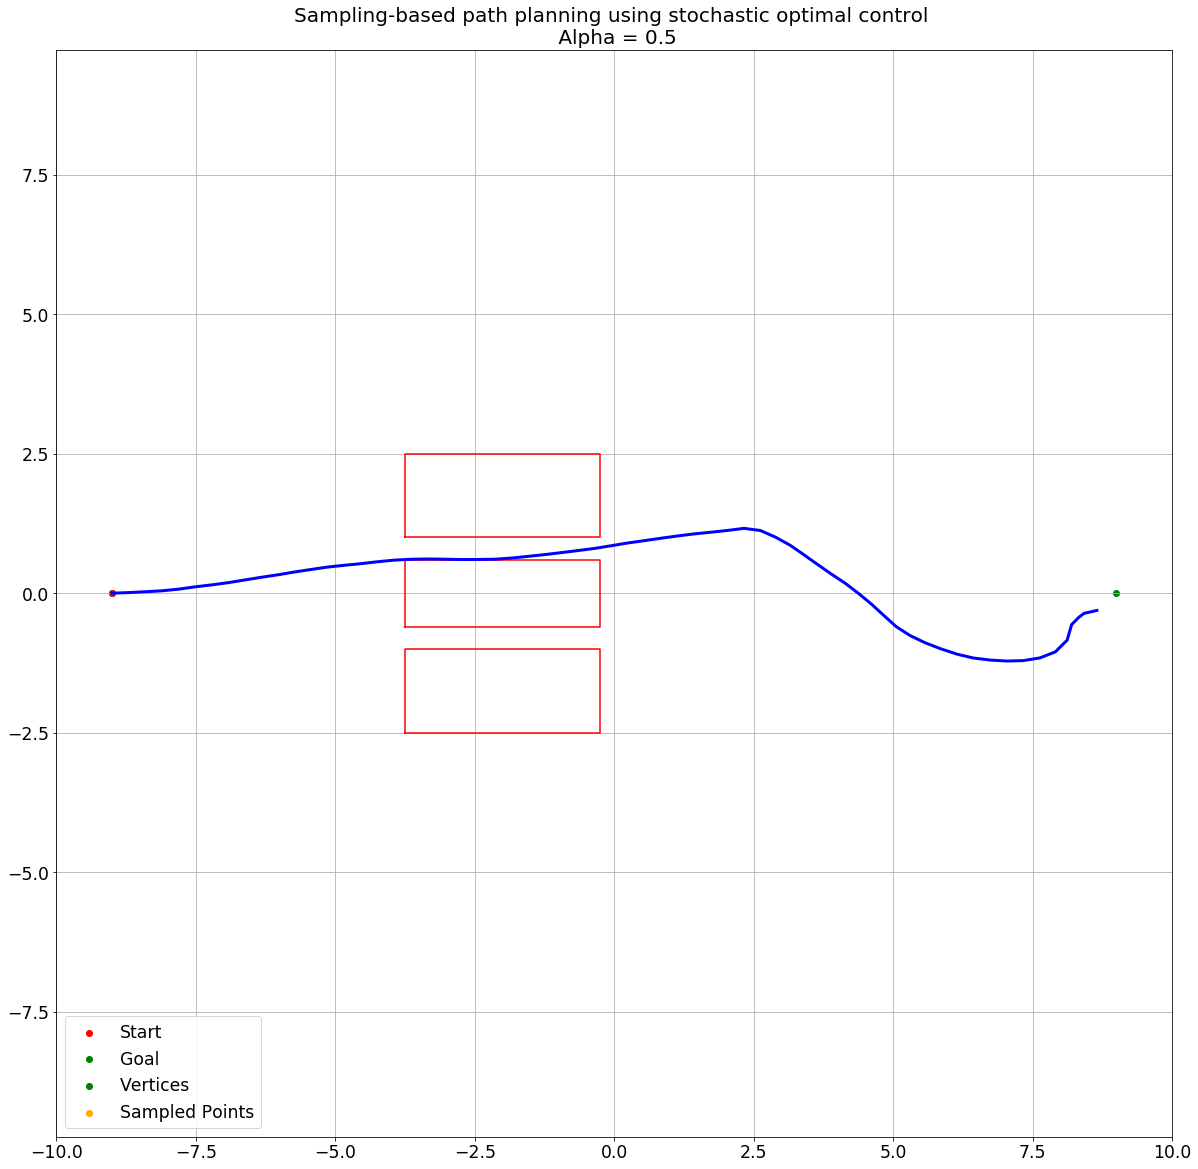

In [22]:
sampleRRT.extractPath()

In [23]:
%tb

No traceback available to show.


In [ ]:
# print math.acos((-3.1653601000712599--3.4387283982119032)/sampleRRT.velocity)/1.6353092635358244
# print math.asin((-0.99851491980809282--0.87521641307593201)/sampleRRT.velocity)/1.6353092635358244

In [ ]:
# math.sin(-0.0150810625518)

In [ ]:
# print len(sampleRRT.verticesSteered)
# print len(sampleRRT.vertices)
# print deltaXTime

In [ ]:
# sampleRRT.plotStore.vInit

In [ ]:
# [v.getState()[3] for v in sampleRRT.path]

In [ ]:
# sampleRRT.verticesSteered[sampleRRT.path[-2].getState()[-1]].getState()
# sampleRRT.path[-2].getState()

In [ ]:
# plotPath(sampleRRT.path[20:])

# Test if rewired vertices have a feasible control path between them

In [26]:
#...

# Load sample RRT file (ignore if you ran the sample RRT above)

In [ ]:
RRTload = dill.load(open('/home/ankit/Documents/Thesis/12_11_19_10_52_10_double_obstacle_alpha_0.5/PI_RRT_7.p','rb'))

In [ ]:
print RRTload.vertices[0].getState()

# Load PI-RRT dill file

In [28]:
pi_rrt = dill.load(open('/home/ankit/Documents/Thesis/12_11_19_10_52_10_double_obstacle_alpha_0.5/PI_RRT_7.p','rb'))

In [29]:
pi_rrt.variables

{'Lambda': 10,
 'M': 5,
 'alpha': 0.5,
 'alphas': [0.25, 0.5, 1.0],
 'controlledSteering': True,
 'dt': 0.1,
 'explorationFactor': 2.0,
 'goalDist': 0.5,
 'lastSteerOnly': True,
 'numStepsSteering': 5,
 'obstacleType': 'double',
 'obstacleTypes': ['single', 'double'],
 'plottingInterval': 'end',
 'r': 4.0,
 'runType': 'pirrt',
 'runTypes': ['rrt', 'rrtloop', 'pirrt'],
 'saveDir': '/home/ankit/Documents/Thesis/12_11_19_10_52_10_double_obstacle_alpha_0.5/',
 'searchRadius': 5,
 'steeringRatio': 1,
 'tHorizon': 1,
 'useRRTStar': False,
 'vGoal': [9.0, 0.0, 0.0, 10.0, 0.0, 0.0],
 'vInit': (6.865838797164972,
  5.547902330921208,
  -1.7794947594684765,
  31.5,
  -0.060729725808867693,
  -1),
 'velocity': 5,
 'wheelBase': 2.0}

# Analyze Sample RRT

In [30]:
rrtStates = pi_rrt.constructStatesMatrix(sampleRRT.pathReversed)
controlSplineRRT = interp1d(rrtStates[:, 3], rrtStates[:, 4], fill_value='extrapolate')

len path is 65


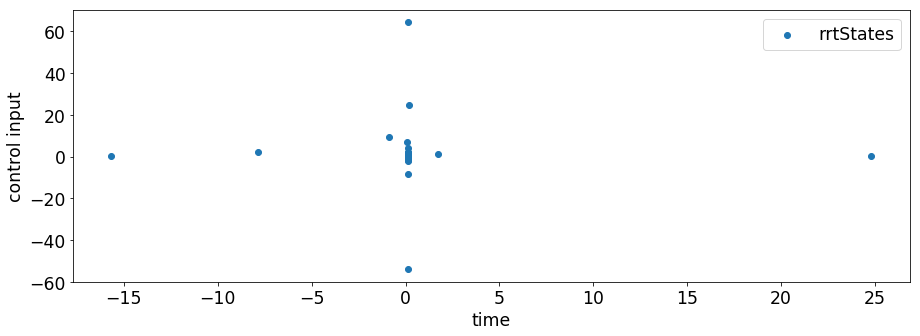

In [31]:
scatter(rrtStates[:,3],rrtStates[:,4])
xlabel('time')
ylabel('control input')
legend(['rrtStates'])

In [32]:
rrtStates[:,3]

array([  0.11998917,   0.11999742,   0.11999027,   0.11999956,
         0.11999779,   0.11999538,   0.11999627,   0.11999785,
         0.11999649,   0.11999656,   0.1200011 ,   0.11999809,
         0.11999646,   0.11999972,   0.11999917,   0.11999232,
         0.12000052,   0.1199928 ,   0.12000056,   0.11999571,
         0.11999678,   0.12000251,   0.11999259,   0.1199962 ,
         0.11999874,   0.11999652,   0.11999537,   0.11999548,
         0.12000209,   0.1199983 ,   0.11995178,   0.11999901,
         0.11999967,   0.11999659,   0.11999848,   0.11999256,
         0.11999604,   0.1199993 ,   0.11999129,   0.11997942,
         0.11998739,   0.11999275,   0.11996863,   0.1199969 ,
         0.11999422,   0.11999212,   0.11999719,   0.11998917,
         0.12000244,  -7.87020615,   0.11998073,   0.11980277,
         1.75252882, -15.70301913,   0.11986821,  24.81909004,
         0.119997  ,   0.11014948,   0.11998016,   0.11442385,
         0.068447  ,  -0.85246367,   0.12006013,   0.11

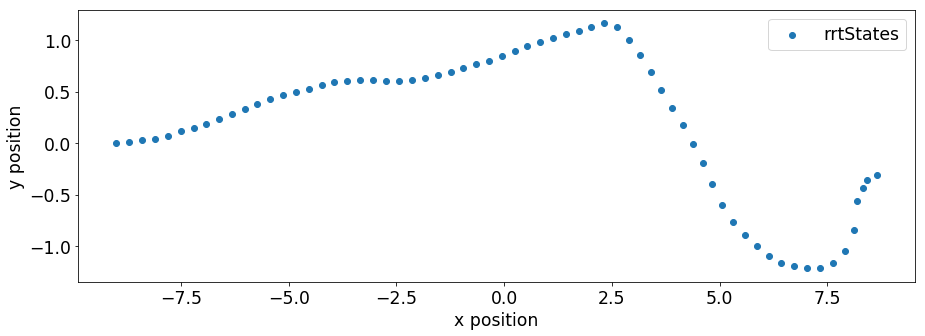

In [33]:
scatter(rrtStates[:,0],rrtStates[:,1])
xlabel('x position')
ylabel('y position')
legend(['rrtStates'])

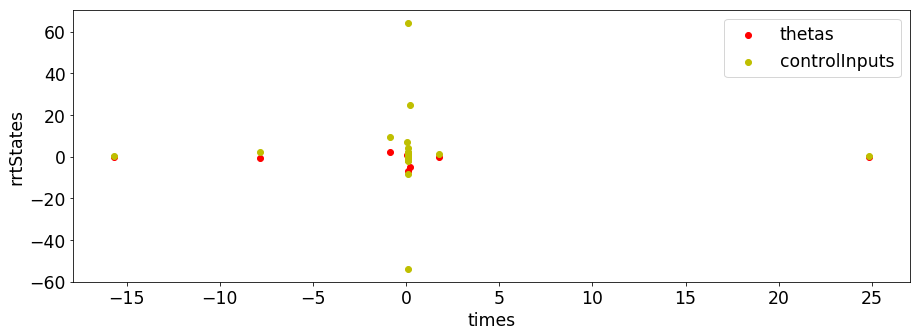

In [34]:
scatter(rrtStates[:,3],rrtStates[:,2],color='r')
scatter(rrtStates[:,3],rrtStates[:,4],color='y')
xlabel('times')
ylabel('rrtStates')
legend(['thetas','controlInputs'])

In [35]:
# times = np.arange(0,max(rrtStates[:,3]),0.1)
controlInputs = deepcopy(rrtStates[:,3])
for i,time in enumerate(rrtStates[:,3]):
    controlInputs[i] = controlSplineRRT(rrtStates[:,3][i])

In [36]:
print rrtStates[:,3].shape

(65,)


In [37]:
print controlSplineRRT(rrtStates[:,3][10])
print rrtStates[:,3][10]
print rrtStates[:,4][10]

0.253745120392
0.120001101095
0.253745120392


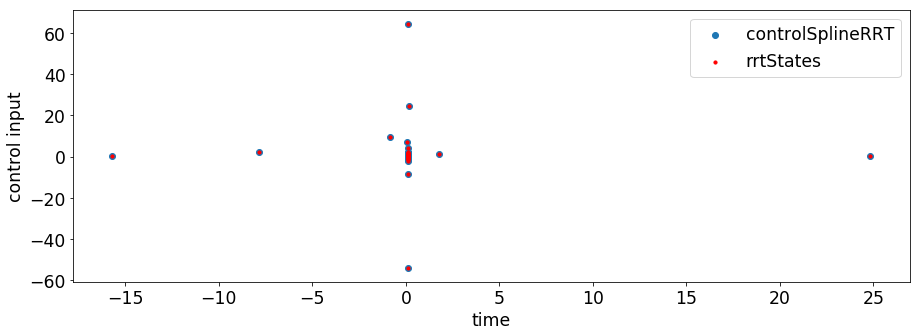

In [38]:
scatter(rrtStates[:,3],controlInputs)
xlabel('time')
ylabel('control input')
scatter(rrtStates[:,3],rrtStates[:,4],color='r',s=10)
legend(['controlSplineRRT','rrtStates'])

# The graph below shows the parent indices for the vertices that are steered to. The graph shows mainly that with rewiring of the vertices, the parents are generally added in a linear and sequential fashion along the graph, with larger additions closer to the appropriate point in the graph and smaller additions further. just look below.

In [39]:
parentList = []
for i,v in enumerate(sampleRRT.verticesSteered):
    parentList.extend([sampleRRT.verticesSteered[i].getState()[-1]])

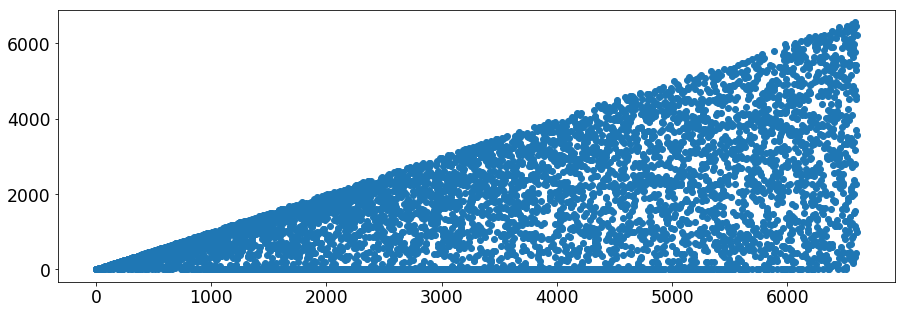

In [40]:
plt.scatter(np.arange(len(parentList)),parentList)

# Reconstruct the path found in the sample RRT using the control spline

Action Item: Make convention of accesing path from sample RRTs such that the path attribute contains a list that begins with the initial state and ends at the terminated state. Currently, the pathReversed attribute contains that ordering but not the path attribute. 

In [41]:
def reconstructPath(inputRRT,controlDiscretation): 
    inputRRTStates = pi_rrt.constructStatesMatrix(inputRRT.pathReversed)
    controlSplineInputRRT = interp1d(inputRRTStates[:, 3], inputRRTStates[:, 4], fill_value='extrapolate')
    reconstructedPath = [inputRRT.pathReversed[0]]
    for i in range(int(max(inputRRTStates[:,3]) / (controlDiscretation))):
        dx = inputRRT.velocity * cos(reconstructedPath[-1].theta)
        dy = inputRRT.velocity * sin(reconstructedPath[-1].theta)
        dtheta = controlSplineInputRRT(reconstructedPath[-1].time + (controlDiscretation)) / inputRRT.r
#         dtheta = trapz(inputRRTStates[0:i,4],dx=0.01)
        newVertex = Vertex(reconstructedPath[-1].x + (controlDiscretation * dx), reconstructedPath[-1].y + \
            (controlDiscretation * dy), reconstructedPath[-1].theta + dtheta, reconstructedPath[-1].time + \
            controlDiscretation, dtheta*inputRRT.r)
        reconstructedPath.append(newVertex)
    return reconstructedPath

In [42]:
inputRRTStates = pi_rrt.constructStatesMatrix(sampleRRT.pathReversed)
print max(inputRRTStates[:,3]) / (sampleRRT.dt)
print inputRRTStates[:,3]

len path is 65
2481.90900424
[  0.11998917   0.11999742   0.11999027   0.11999956   0.11999779
   0.11999538   0.11999627   0.11999785   0.11999649   0.11999656
   0.1200011    0.11999809   0.11999646   0.11999972   0.11999917
   0.11999232   0.12000052   0.1199928    0.12000056   0.11999571
   0.11999678   0.12000251   0.11999259   0.1199962    0.11999874
   0.11999652   0.11999537   0.11999548   0.12000209   0.1199983
   0.11995178   0.11999901   0.11999967   0.11999659   0.11999848
   0.11999256   0.11999604   0.1199993    0.11999129   0.11997942
   0.11998739   0.11999275   0.11996863   0.1199969    0.11999422
   0.11999212   0.11999719   0.11998917   0.12000244  -7.87020615
   0.11998073   0.11980277   1.75252882 -15.70301913   0.11986821
  24.81909004   0.119997     0.11014948   0.11998016   0.11442385
   0.068447    -0.85246367   0.12006013   0.11964145   0.17964145]


In [43]:
def reconstructPathTheta(inputRRT,controlDiscretation): 
    inputRRTStates = pi_rrt.constructStatesMatrix(inputRRT.pathReversed)
    thetaSplineInputRRT = interp1d(inputRRTStates[:, 3], inputRRTStates[:, 2], fill_value='extrapolate')
    reconstructedPath = [inputRRT.pathReversed[0]]
    for i in range(int(max(inputRRTStates[:,3]) / (controlDiscretation))):
        dx = inputRRT.velocity * cos(reconstructedPath[-1].theta)
        dy = inputRRT.velocity * sin(reconstructedPath[-1].theta)
        theta = thetaSplineInputRRT(reconstructedPath[-1].time + (controlDiscretation))
        newVertex = Vertex(reconstructedPath[-1].x + (controlDiscretation * dx), reconstructedPath[-1].y + \
            (controlDiscretation * dy), theta, reconstructedPath[-1].time + \
            controlDiscretation, theta*inputRRT.r)
        reconstructedPath.append(newVertex)
    return reconstructedPath

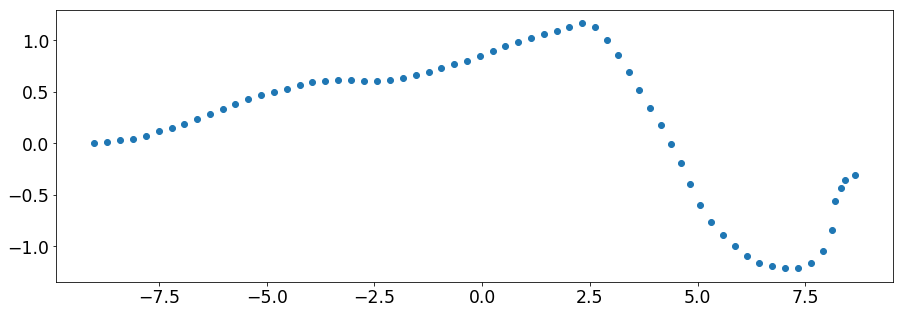

In [84]:
scatter(rrtStates[:,0],rrtStates[:,1])

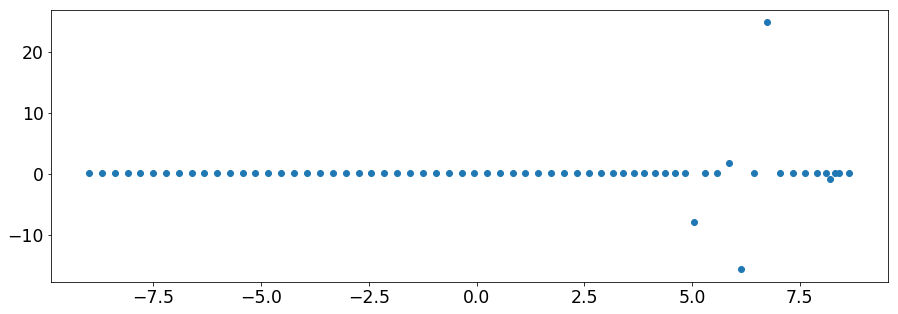

In [85]:
scatter(rrtStates[:,0],rrtStates[:,3])

In [90]:
min(rrtStates[:,3])

-15.703019126473972

len path is 65


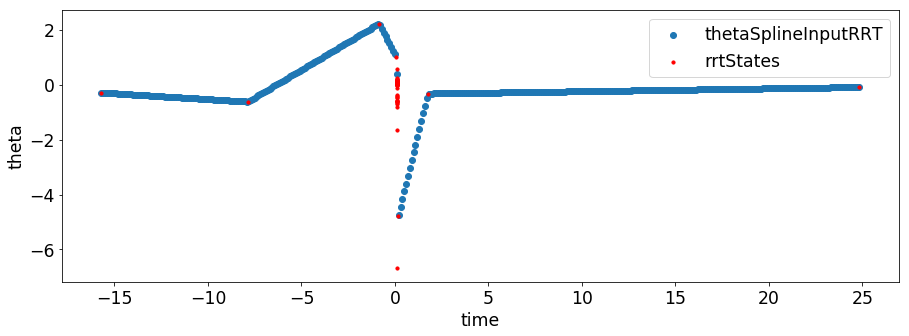

In [78]:
inputRRTStates = pi_rrt.constructStatesMatrix(sampleRRT.pathReversed)
thetaSplineInputRRT = interp1d(inputRRTStates[:, 3], inputRRTStates[:, 2], fill_value='extrapolate')
times = np.arange(min(rrtStates[:,3]),max(rrtStates[:,3]),0.1)
thetas = deepcopy(times)
for i,time in enumerate(times):
    thetas[i] = thetaSplineInputRRT(time)
scatter(times,thetas)
xlabel('time')
ylabel('theta')
scatter(rrtStates[:,3],rrtStates[:,2],color='r',s=10)
legend(['thetaSplineInputRRT','rrtStates'])

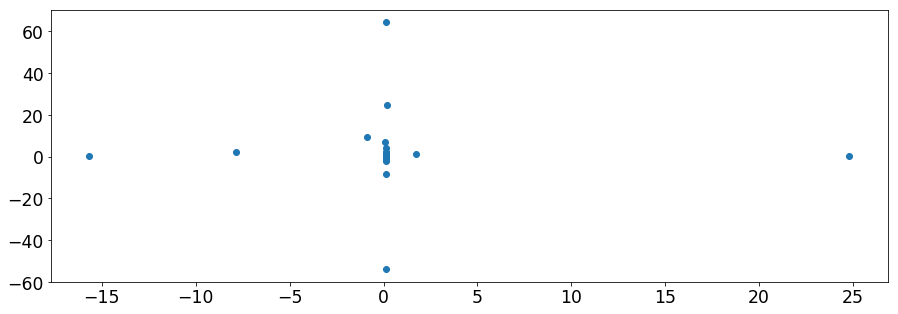

In [92]:
scatter(rrtStates[:,3],rrtStates[:,4])

In [44]:
timeDifferences = []
for i,v in enumerate(sampleRRT.pathReversed):
    timeDifference = v.time-sampleRRT.pathReversed[i-1].time
#     print "v.time: " + str(v.time)
#     print "sampleRRT.pathReversed[i-1].time: " + str(sampleRRT.pathReversed[i-1].time)
#     print "timeDifference: " + str(timeDifference)
#     print v.time-sampleRRT.pathReversed[i-1].time
    timeDifferences.append(timeDifference)
timeDifferences[0] = 0.0
meanTimeDifference = mean(timeDifferences)
print meanTimeDifference

0.000917727345052


# This section is for figuring out time to get from a rewired parent to a rewired child in RRT*

In [100]:
v1 = Vertex(x = 0.,y = 0.)
v2 = Vertex(x = -4.,y = -4.)

In [101]:
print math.acos((v2.x-v1.x)/sampleRRT.velocity)
# deltaXTime = acos((v.x-steeredVertex.x)/self.velocity)/v.controlInput
# deltaYTime = asin((v.y-steeredVertex.y)/self.velocity)/v.controlInput

2.4980915448


In [45]:
reconstructedPath = reconstructPath(sampleRRT,controlDiscretation=sampleRRT.dt)
rrtStatesReconstructedPath = pi_rrt.constructStatesMatrix(reconstructedPath)
reconstructedPathTheta = reconstructPathTheta(sampleRRT,controlDiscretation=sampleRRT.dt)
rrtStatesReconstructedPathTheta = pi_rrt.constructStatesMatrix(reconstructedPathTheta)

len path is 65
len path is 2482
len path is 65
len path is 2482


In [46]:
sampleRRT.pathReversed[0].getState()

(-9.0, 0.0, 0.0, 0.11998917144770735, 0.0, 0)

In [47]:
newPathVertices5 = [sampleRRT.pathReversed[0]]
for i,val in enumerate(rrtStates[:,2]):
    dx = pi_rrt.velocity * cos(newPathVertices5[-1].theta)
    dy = pi_rrt.velocity * sin(newPathVertices5[-1].theta)
    newVertex = Vertex(newPathVertices5[-1].x + ((meanTimeDifference) * dx), newPathVertices5[-1].y + \
        ((meanTimeDifference) * dy), val, newPathVertices5[-1].time + \
        (meanTimeDifference), val*sampleRRT.r)
    newPathVertices5.append(newVertex)

In [48]:
sampleRRT2 = RRTStar(variables,plotStore)
sampleRRT2.pathReversed = newPathVertices5
reconstructedPath2 = reconstructPath(sampleRRT2,controlDiscretation=sampleRRT2.dt)
rrtStatesReconstructedPath2 = pi_rrt.constructStatesMatrix(reconstructedPath2)

rrt initialized with (-9.0, 0.0, 0.0, 0.0, 0.0, 0)
len path is 66
len path is 18


In [49]:
endVertex = -1

In [50]:
print len(sampleRRT.vertices)
print len(sampleRRT.verticesSteered)

1
6604


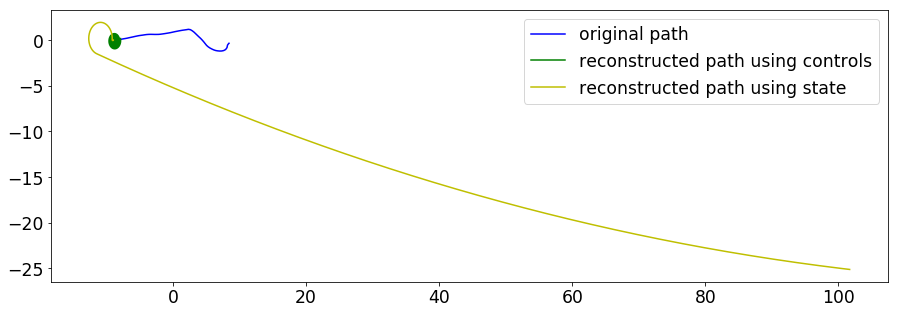

In [51]:
plotPath(sampleRRT.pathReversed[0:endVertex])
plotPath(reconstructedPath,color='g')
# plotPath(reconstructedPath2,color='r')
plotPath(reconstructedPathTheta,color='y')
legend(['original path','reconstructed path using controls','reconstructed path using state'])

In [52]:
print len(reconstructedPath)
print len(sampleRRT.pathReversed)
print len(reconstructedPathTheta)

2482
65
2482


In [ ]:
scatter(rrtStatesReconstructedPath[:,3],rrtStatesReconstructedPath[:,4],color='r',s=5)
scatter(rrtStatesReconstructedPathTheta[:,3],rrtStatesReconstructedPathTheta[:,4],color='g',s=8)
xlabel('times')
ylabel('thetas')
legend(['reconstructed path using controls','reconstructed path using state'])

In [ ]:
thetaDifferences = deepcopy(rrtStates[:,2])
for i,rrtState in enumerate(rrtStates[:,2]):
    thetaDifferences[i] = rrtStates[i,2]-rrtStates[i-1,2]

In [ ]:
integrationTime = max(rrtStates[:,3])/(sampleRRT.dt*sampleRRT.numStepsSteering)

In [ ]:
times = np.arange(len(rrtStates[:,3]))
scatter(times,rrtStates[:,3])

In [ ]:
scatter(rrtStates[:,3],thetaDifferences)
xlabel('times')
ylabel('thetaDifferences')
scatter(rrtStates[:,3],rrtStates[:,4])
legend(['thetaDifferences','rrtStates'])

In [ ]:
integratedThetas = deepcopy(rrtStates[:,2])
for i,rrtState in enumerate(rrtStates[:,4]):
    integratedThetas[i] = trapz(rrtStates[0:i,4])
#     integratedThetas[i] = trapz(thetaDifferences[0:i])

In [ ]:
scatter(rrtStates[:,3],rrtStates[:,4],color='r')

In [ ]:
scatter(rrtStates[:,3],rrtStates[:,2],color='r')
# scatter(rrtStatesReconstructedPathTheta[:,3],rrtStatesReconstructedPathTheta[:,2],color='g')
xlabel('times')
ylabel('thetas')
# For integratedThetas using rrtStates[:,4]
# scatter(rrtStates[:,3],integratedThetas/(sampleRRT.r*integrationTime),color='b')
scatter(rrtStates[:,3],integratedThetas/42,color='b')
# For integratedThetas using thetaDifferences
# scatter(rrtStates[:,3]-0.15,integratedThetas-0.4,color='b')
# legend(['rrtStates','rrtStatesReconstructedPath'])

In [ ]:
scatter(rrtStates[:,3],rrtStates[:,4],color='r')
scatter(rrtStatesReconstructedPathTheta[:,3],rrtStatesReconstructedPathTheta[:,4],color='g',s=5)
xlabel('times')
ylabel('controlInputs')
legend(['rrtStates','rrtStatesReconstructedPath'])

In [ ]:
print rrtStates[:,3]

In [ ]:
print integratedThetas[-1]
print trapz(rrtStates[1:,4],dx=0.1)

In [ ]:
print reconstructedPath[-1].getState()[3]
print len(reconstructedPath)
print newPathVertices5[-1].getState()[3]
print len(newPathVertices5)
print sampleRRT.pathReversed[-1].getState()[3]
print len(sampleRRT.pathReversed)

In [ ]:
plotPath(sampleRRT.pathReversed)
plotObstacles(sampleRRT)
plotPath(reconstructedPath2,color='g')
plotPath(newPathVertices5,color='y')
plotPath(reconstructPath(sampleRRT,controlDiscretation=sampleRRT.dt))

In [ ]:
hist([v.getState()[3] for v in newPathVertices5])

In [ ]:
hist([v.getState()[1] for v in sampleRRT.pathReversed])

In [ ]:
hist(rrtStates[:,1])

In [ ]:
hist([v.controlInput for v in sampleRRT.pathReversed])
hist(rrtStates[:,4])

In [ ]:
print len(newPathVertices4)
print len(sampleRRT.pathReversed)

In [ ]:
plt.hist([v.getState()[4] for v in newPathVertices4])
plt.hist([v.getState()[4] for v in sampleRRT.pathReversed])

# Investigating the compute variation step of PI-RRT

In [ ]:
verticesSteered = dill.load(open('/home/ankit/Documents/Thesis/04_29_19_12_43_21_double_obstacle_alpha_0.5/RRT_verticesSteered.p','rb'))

In [ ]:
for i,v in enumerate(verticesSteered):
    print v.getState()
    print pi_rrt.RRT.obstacleFree(v,verticesSteered[v.parent])

In [ ]:
pi_rrt.computeVariation2()

In [ ]:
nominalPath = []
for v in pi_rrt.rrtStates:
    nominalPath.append(Vertex(*v))
print nominalPath

In [ ]:
# for t in pi_rrt.trajectories:
#     plotPath(t)
plotObstacles(pi_rrt.RRT)
# plotPath(pi_rrt.path,color='y')
# plotPath(newPathVertices,color='c')
scatterPath(newPathVertices2,color='k')
plotPath(nominalPath,color='k')
plotPath(newPathVertices3)

In [ ]:
print len(sampleRRT.vertices)
print len(sampleRRT.verticesSteered)

In [ ]:
for v in sampleRRT.pathReversed:
    print v.time

In [ ]:
plotPath(pi_rrt.path,color='y')
plotPath(newPathVertices,color='c')
plotPath(newPathVertices2,color='k')

In [ ]:
(t, U) = pi_rrt.computeVariation2()

In [ ]:
for i,time in enumerate(t):
    print pi_rrt.controlSplineRRT(time)
    print 'U[i]: '+ str(U[i])

In [ ]:
plotTimes = np.arange(0,10,0.5)

In [ ]:
scatter([v.getState()[0] for v in nominalPath],[v.getState()[1] for v in nominalPath],color='g')

In [ ]:
# plot(plotTimes,pi_rrt.controlSplinePathIntegral(plotTimes),color='r')
plot(plotTimes,pi_rrt.controlSplineRRT(plotTimes),color='b')
# scatter(t,U,color='g')
# scatter(t,pi_rrt.controlSplineRRT(t),color='c')
plot(pi_rrt.rrtStates[:,-2],pi_rrt.rrtStates[:,-1])
scatter([v.getState()[3] for v in nominalPath],[v.getState()[4] for v in nominalPath],color='k')

In [ ]:
print [v.getState()[4] for v in nominalPath]

In [ ]:
size(pi_rrt.controlSplinePathIntegral(plotTimes))
size(plotTimes)

In [ ]:
newPathVertices = [pi_rrt.path[0]]
for i in range(int(pi_rrt.tHorizon / pi_rrt.controlDiscretation)):
    dx = pi_rrt.velocity * cos(newPathVertices[-1].theta)
    dy = pi_rrt.velocity * sin(newPathVertices[-1].theta)
    dtheta = pi_rrt.controlSplinePathIntegral(newPathVertices[-1].time + pi_rrt.controlDiscretation * i) / pi_rrt.r
    newVertex = Vertex(newPathVertices[-1].x + pi_rrt.controlDiscretation * dx, newPathVertices[-1].y + \
        pi_rrt.controlDiscretation * dy, newPathVertices[-1].theta + dtheta, newPathVertices[-1].time + \
        pi_rrt.controlDiscretation * i, dtheta)
    newPathVertices.append(newVertex)

In [ ]:
newPathVertices2 = [pi_rrt.path[0]]
for i in range(int(pi_rrt.tHorizon / pi_rrt.controlDiscretation)):
    dx = pi_rrt.velocity * cos(newPathVertices2[-1].theta)
    dy = pi_rrt.velocity * sin(newPathVertices2[-1].theta)
    dtheta = pi_rrt.controlSplineRRT(newPathVertices2[-1].time + pi_rrt.controlDiscretation * i) / pi_rrt.r
    newVertex = Vertex(newPathVertices2[-1].x + pi_rrt.controlDiscretation * dx, newPathVertices2[-1].y + \
        pi_rrt.controlDiscretation * dy, newPathVertices2[-1].theta + dtheta, newPathVertices2[-1].time + \
        pi_rrt.controlDiscretation * i, dtheta)
    newPathVertices2.append(newVertex)

In [ ]:
newPathVertices3 = [pi_rrt.path[0]]
for i in range(int(max(pi_rrt.rrtStates[:,3]) / (pi_rrt.controlDiscretation))):
    dx = pi_rrt.velocity * cos(newPathVertices3[-1].theta)
    dy = pi_rrt.velocity * sin(newPathVertices3[-1].theta)
    dtheta = pi_rrt.controlSplineRRT(newPathVertices3[-1].time + (pi_rrt.controlDiscretation)) / pi_rrt.r
    newVertex = Vertex(newPathVertices3[-1].x + (pi_rrt.controlDiscretation) * dx, newPathVertices3[-1].y + \
        (pi_rrt.controlDiscretation) * dy, newPathVertices3[-1].theta + dtheta, newPathVertices3[-1].time + \
        (pi_rrt.controlDiscretation), dtheta)
    newPathVertices3.append(newVertex)

In [ ]:
for i,v in enumerate(pi_rrt.trajectories[1]):
    print pi_rrt.RRT.obstacleFree(pi_rrt.trajectories[1][i+1],v)

In [ ]:
for v in self.verticesSteered:
    if pi_rrt.RRT.obstacleFree(v,pi_rrt.verticesSteered[v.parent])

In [ ]:
pi_rrt.trajectories[1]

In [ ]:
print pi_rrt.RRT.obstacleFreeVertices(pi_rrt.trajectories[0],vertex='True')

In [ ]:
print max(pi_rrt.rrtStates[:,3])

In [ ]:
timeInputs = []
controlInputs = []
for p in pi_rrt.RRT.path:
    print p.getState()
    controlInputs.append(p.controlInput)
    timeInputs.append(p.time)

In [ ]:
controlSplineRRT = interp1d(timeInputs, controlInputs, fill_value='extrapolate')

In [ ]:
timeInputs

In [ ]:
controlOutputs = []
for p in pi_rrt.RRT.path:
#     controlOutputs.append(pi_rrt.controlSplineRRT(p.time))
    controlOutputs.append(controlSplineRRT(p.time))

In [ ]:
print controlSplineRRT(1)
print pi_rrt.controlSplineRRT(1)

In [ ]:
scatter(timeInputs,controlInputs)
# plot(timeInputs,controlOutputs,'g')

In [ ]:
xValues = np.arange(1,100,1)

In [ ]:
yValues = np.arange(1,100,1)

In [ ]:
for i,x in enumerate(xValues): 
    yValues[i] = pi_rrt.controlSplineRRT(x)

In [ ]:
plot(xValues[0:10],yValues[0:10])

In [ ]:
yValues

In [ ]:
pi_rrt.controlSplineRRT(102.0)

# PI-RRT START: I need to create a plotStore to run PIRRT. This really needs to be fixed later

In [ ]:
from plotStore import plotStore

In [ ]:
saveDir = '/'+'/'.join(os.getcwd().split('/')[1:-1])+'/'+datetime.datetime.now().strftime("%m_%d_%y_%H_%M_%S")+'_'+\
            variables['obstacleType']+'_obstacle_alpha_'+str(variables['alpha'])+'/'

In [ ]:
plotStore = plotStore(Vertex(*variables['vInit']),Vertex(*variables['vGoal']),saveDir)

In [ ]:
try:
    os.makedirs(saveDir)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
call('rm '+saveDir+'*',shell=True)

# PI RRT

In [ ]:
pi_rrt = PI_RRT(variables,plotStore)

In [ ]:
pi_rrt.runRRT()

In [ ]:
newRRT = RRTStar(pi_rrt.variables,pi_rrt.plotStore)
newRRT.assignControlSpline(pi_rrt.controlSplineRRT, max(pi_rrt.rrtStates[:, 3]))

In [ ]:
newRRT.extractPath()

In [ ]:
pathList = []
for i in range(1,100):
    print ' '
    print 'New Path'
    print ' '
    path = []
    lastVertex = pi_rrt.vInit
    print lastVertex.getState()
    # lastVertex = pi_rrt.vGoal
    path.append(pi_rrt.vInit)
    for i in np.arange(0,4,1):
        newVertices = newRRT.steerControlled(lastVertex,0,lastVertex)
        lastVertex = Vertex(*newVertices[-1])
        path.append(Vertex(*newVertices[-1]))
        print lastVertex.getState()
    pathList.append(path)

In [ ]:
plotPath(pi_rrt.RRT.path,'g')
for p in pathList:
    plotPath(p,'b')
plotObstacles(pi_rrt.RRT)

In [ ]:
for i,p in enumerate(pathList):
    print pi_rrt.RRT.obstacleFreeVertices(p,vertex='True')
#     if pi_rrt.RRT.obstacleFreeVertices(p,vertex='True') == 'True':
#         print i

In [ ]:
plotControlsPath(pi_rrt.RRT.pathReversed,color='r')
for p in pathList:
    plotControlsPath(p,color='g')

In [ ]:
print len(pathList[0])
print len(path)

In [ ]:
function 

In [ ]:
path == pathCompare

In [ ]:
controlInputs = []
timesNominal = []
for v in pi_rrt.RRT.path: 
    controlInputs.append(v.getState()[4])
    timesNominal.append(v.getState()[3])

In [ ]:
times = np.arange(0,max(timesNominal),0.1)

In [ ]:
controlSplineOutputs = []
for t in times: 
#     print('time: '+ str(t))
    controlSplineOutput = pi_rrt.controlSplineRRT(t)
#     print('controlSplineOutput: '+ str(controlSplineOutput))
    # controlSplineOutput += pi_rrt.RRT.generateNoise()
    # print('controlSplineOutput: '+ str(controlSplineOutput))
    controlSplineOutputs.append(controlSplineOutput)

In [ ]:
scatter(times,controlSplineOutputs)
scatter(timesNominal,controlInputs)

In [ ]:
scatter(times,controlSplineOutputs2)

In [ ]:
rrtStates = pi_rrt.constructStatesMatrix(pi_rrt.RRT.pathReversed)

In [ ]:
max(timesNominal)

In [ ]:
#controlSplineRRT2 = interp1d(rrtStates[:,3], rrtStates[:,4], fill_value='extrapolate')
controlSplineRRT2 = interp1d(timesNominal, controlInputs, fill_value='extrapolate')

In [ ]:
controlSplineOutputs2 = []
for t in times: 
    print('time: '+ str(t))
    controlSplineOutput2 = controlSplineRRT2(t)
    print('controlSplineOutput: '+ str(controlSplineOutput2))
    controlSplineOutput += pi_rrt.RRT.generateNoise()
    print('controlSplineOutput: '+ str(controlSplineOutput))
    controlSplineOutputs2.append(controlSplineOutput2)

In [ ]:
pi_rrt.RRT.pathReversed[-1].getState()

In [ ]:
mean(controlSplineOutputs2)

In [ ]:
controlSplineRRT2(8.0) == [np.inf]

In [ ]:
c

# Spline interpolation is failing because extrapolation beyond time of last vertex will not work. Could use interpolation flag to fix but I dont think this is a good idea.

In [ ]:
x = np.arange(0,10,0.1)
y = pi_rrt.controlSplineRRT(x)

In [ ]:
scatter(x,y)

In [ ]:
x[np.where(y==inf)]

In [ ]:
max(x)

In [ ]:
pi_rrt.controlSplineRRT(4.4)

In [ ]:
pi_rrt.generateTrajectories()

In [ ]:
newRRT = RRTStar(pi_rrt.variables,pi_rrt.plotStore)
newRRT.assignControlSpline(pi_rrt.controlSplineRRT)

In [ ]:
newRRT.plottingInterval = 'end'

# Conclusion: Since generate trajectories relies on the nominal control values to generate new control values, when interpolation on the nominal spline occurs after exhaustion of actual vertex times, you get a (mostly) linear interpolation i.e. the same control values (albeit with increasing magnitude) get applied with increasing dt. This is why you see the spiral paths below. This is probably one of the reasons why PI-RRTStar is not converging, and probably impacts PI-RRT too. 

In [ ]:
newRRT.extractPath()

# Let's look at rrt states matrix

In [ ]:
pi_rrt.rrtStates

In [ ]:
pi_rrt.RRT.vertices[-1].getState()

# Let's switch to RRT and see what happens. Now I have to create a copy of everything. This fucking sucks

In [ ]:
variablesCopy = deepcopy(variables)

In [ ]:
variablesCopy['useRRTStar'] = False

In [ ]:
variablesCopy['plottingInterval'] = 'end'

In [ ]:
saveDirCopy = '/'+'/'.join(os.getcwd().split('/')[1:-1])+'/'+datetime.datetime.now().strftime("%m_%d_%y_%H_%M_%S")+'_'+\
            variablesCopy['obstacleType']+'_obstacle_alpha_'+str(variablesCopy['alpha'])+'/'

In [ ]:
from plotStore import plotStore

In [ ]:
plotStoreCopy = plotStore(Vertex(*variablesCopy['vInit']),Vertex(*variablesCopy['vGoal']),saveDirCopy)

In [ ]:
try:
    os.makedirs(saveDirCopy)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
call('rm '+saveDirCopy+'*',shell=True)

In [ ]:
pi_rrt_copy = PI_RRT(variablesCopy,plotStoreCopy)

In [ ]:
pi_rrt_copy.runRRT()

In [ ]:
pi_rrt_copy.controlSplineRRT

In [ ]:
xCopy = np.arange(0,10,0.1)
yCopy = pi_rrt_copy.controlSplineRRT(xCopy)

In [ ]:
scatter(xCopy,yCopy)

# GARBAGE

In [ ]:
u = [v.controlInput for v in pi_rrt.RRT.pathReversed]
times = [v.time for v in pi_rrt.RRT.pathReversed]
x = [v.x for v in pi_rrt.RRT.pathReversed]
y = [v.y for v in pi_rrt.RRT.pathReversed]
t = [v.theta for v in pi_rrt.RRT.pathReversed]
plotPath(pi_rrt.RRT.pathReversed)
spline = interp1d(times, u, fill_value='extrapolate')
for j in range(10):
    xR = np.zeros(len(x))
    yR = np.zeros(len(y))
    tR = np.zeros(len(t))
    xR[0] = x[0]
    yR[0] = y[0]
    tR[0] = t[0]
    for i,v in enumerate(pi_rrt.RRT.pathReversed[:-1]):
        xR[i+1] = xR[i] + pi_rrt.RRT.dt * pi_rrt.RRT.velocity * cos(tR[i])
        yR[i+1] = yR[i] + pi_rrt.RRT.dt * pi_rrt.RRT.velocity * sin(tR[i])
        tR[i+1] = tR[i] + (spline(times[i])/pi_rrt.RRT.r) + pi_rrt.RRT.generateNoise()
#     plot(x,y)
    scatter(xR,yR)

In [ ]:
fig = figure(0,(20,10))
plotRRTVertices(pi_rrt.RRT,start=0,end=45)
plotPath(pi_rrt.RRT.path)

In [ ]:
print pi_rrt.RRT.vertices[45].getState()

In [ ]:
pi_rrt.generateTrajectories2()

In [ ]:
totalCosts = np.zeros(len(pi_rrt.trajectories))
trajectoryLengths = [ len(t) for t in pi_rrt.trajectories ]
regCoef = 3.0
if max(trajectoryLengths) < 4:
    trajectoryStates = np.zeros((len(pi_rrt.trajectories), 4, 5))
else:
    trajectoryStates = np.zeros((len(pi_rrt.trajectories), max(trajectoryLengths), 5))
if min(trajectoryLengths) < 4:
    trajectoryLengths = [ 4 for t in pi_rrt.trajectories ]
for k, trajectory in enumerate(pi_rrt.trajectories):
    print 'len(trajectory) is: ' + str(len(trajectory))
    trajectoryStates[k, :max(len(trajectory), 4), :] = pi_rrt.constructStatesMatrix(trajectory)
    pathCosts = np.zeros(len(trajectory))
    noiseCosts = np.zeros(len(trajectory))
    for i, v in enumerate(trajectory[:-1]):
        pathCosts[i] += trajectoryStates[k, i, 0:3].dot(pi_rrt.Q).dot(trajectoryStates[k, i, 0:3].T)
        pathCosts[i] += 0.5 * pi_rrt.controlSplineRRT(trajectoryStates[k, i, 3]).T * pi_rrt.R * pi_rrt.controlSplineRRT(trajectoryStates[k, i, 3])
        noiseCosts[i] += pi_rrt.controlSplineRRT(trajectoryStates[k, i, 3]) * trajectoryStates[k, i, 4]
    totalCost = np.trapz(pathCosts[:-1], trajectoryStates[k, :len(trajectory) - 1, 3])
    endStateDiff = trajectoryStates[k, -1, 0:3] - np.array(pi_rrt.RRT.vGoal.getState()[0:3])
    totalCost += endStateDiff.dot(pi_rrt.Qf).dot(endStateDiff.T)
    totalCost += np.trapz(noiseCosts[:-1], trajectoryStates[k, :len(trajectory) - 1, 3])
    totalCosts[k] = totalCost / regCoef

trajectoryDesirability = np.exp(-totalCosts / pi_rrt.Lambda)
print 'trajectoryDesirability: ' + str(trajectoryDesirability)
while sum(trajectoryDesirability) == 0:
    regCoef = regCoef * 3
    totalCosts = totalCosts / regCoef
    trajectoryDesirability = np.exp(-totalCosts / self.Lambda)
print 'trajectoryDesirability: ' + str(trajectoryDesirability)

weights = trajectoryDesirability / sum(trajectoryDesirability)
dU = np.zeros(min(trajectoryLengths))
for k, trajectory in enumerate(pi_rrt.trajectories):
    dU += weights[k] * trajectoryStates[k, :min(trajectoryLengths), 4]
    print 'dU: ' + str(dU)

minTrajectoryIndex = trajectoryLengths.index(min(trajectoryLengths))
print [v.time for v in pi_rrt.RRT.pathReversed]
U = np.zeros(min(trajectoryLengths))
t = np.zeros(min(trajectoryLengths))
for i in range(min(trajectoryLengths)):
    t[i] = trajectoryStates[minTrajectoryIndex,i,3]
    U[i] = pi_rrt.controlSplineRRT(t[i]) + dU[i]  

plot(t, U)

In [ ]:
from scipy.interpolate import interp1d

In [ ]:
print t

In [ ]:
print pi_rrt.path[-1].getState()

In [ ]:
for i in range(int(pi_rrt.tHorizon / pi_rrt.controlDiscretation)):
    print pi_rrt.path[-1].time+ pi_rrt.controlDiscretation * i

In [ ]:
controlSplinePathIntegral = interp1d(t, U, fill_value='extrapolate')
pi_rrt.newPathVertices = [pi_rrt.path[-1]]
for i in range(int(pi_rrt.tHorizon / pi_rrt.controlDiscretation)):
    dx = pi_rrt.velocity * cos(pi_rrt.newPathVertices[-1].theta)
    dy = pi_rrt.velocity * sin(pi_rrt.newPathVertices[-1].theta)
    dtheta = pi_rrt.controlSplinePathIntegral(pi_rrt.controlDiscretation * i) / pi_rrt.r
    dtheta += pi_rrt.RRT.generateNoise()
    newVertex = Vertex(pi_rrt.newPathVertices[-1].x + pi_rrt.controlDiscretation * dx, pi_rrt.newPathVertices[-1].y + pi_rrt.controlDiscretation * dy, pi_rrt.newPathVertices[-1].theta + dtheta, pi_rrt.newPathVertices[-1].time + pi_rrt.controlDiscretation * i, dtheta)
    if pi_rrt.RRT.obstacleFree(newVertex, pi_rrt.newPathVertices[-1]) == True:
        pi_rrt.newPathVertices.append(newVertex)
    else:
        pi_rrt.newPathVertices = []
        break

pi_rrt.path.extend(pi_rrt.newPathVertices[1:])

In [ ]:
pi_rrt.executeControl2(*pi_rrt.computeVariation2())

In [ ]:
pi_rrt.RRT.plotAll()

In [ ]:
pi_rrt.runRRT()

In [ ]:
print pi_rrt.rrtStates[:, 3]

In [ ]:
print trajectoryStates[:,:min(trajectoryLengths),3]

In [ ]:
print dU

# Are my noise distributions the same as Oktay's? No :(

In [ ]:
r1 = []
r2 = []
for i in range(1000):
    r1.append(PI_RRT.alpha / PI_RRT.r * np.random.normal(0.0, np.sqrt(PI_RRT.dt))*100)
#     r1.append(PI_RRT.alpha / PI_RRT.r * np.random.normal())
    r2.append(PI_RRT.alpha / PI_RRT.r * np.random.normal()/np.sqrt(PI_RRT.dt))
plt.hist(r1)
# plt.hist(r2)

In [ ]:
times = [v.time for v in pi_rrt.RRT.pathReversed]
print times

In [ ]:
for i in range(1,len(times)):
    print (times[i]-times[i-1])/pi_rrt.dt

In [ ]:
print len(pi_rrt.RRT.vertices)
plotPath(pi_rrt.RRT.pathReversed)
plotRRTVertices(pi_rrt.RRT)

# Visualize PI_RRT pickles

In [ ]:
import dill

In [ ]:
pickleDir = '/home/ankit/Documents/Thesis/12_08_18_20_41_41_double_obstacle_alpha_0.5'

# Get ranges of U and t

In [ ]:
for pik in sorted(glob.glob(pickleDir+'/*.p'),key=lambda name: int(name.split('_')[-1].split('.p')[0])):
    print pik
    PI_RRT = dill.load(open(pik,'rb'))
    print len(PI_RRT.t)
    print max(PI_RRT.U)
    print min(PI_RRT.U)
    print max(PI_RRT.t)
    print min(PI_RRT.t)

# Go through individual PIRRT pickles 

In [ ]:
PI_RRT = dill.load(open(pickleDir+'/RRT_0.p','rb'))

In [ ]:
plotObstacles(PI_RRT.RRT)
plotPath(PI_RRT.RRT.path)
print PI_RRT.RRT.obstacleFreeVertices(PI_RRT.RRT.path,vertex=True)
# for t in PI_RRT.trajectories:
#     plotPath(t,color='r')
#     print PI_RRT.RRT.obstacleFreeVertices(t,vertex=True)

In [ ]:
PI_RRT_previous = dill.load(open(pickleDir+'/PI_RRT_8.p','rb'))

In [ ]:
for t in PI_RRT.trajectories:
    print len(t)

In [ ]:
fig = figure(0,(20,20))
plotControlsRRT(PI_RRT,time=5)
plotControlsTrajectory(PI_RRT,time=5)
scatterControlSplinePathIntegral(PI_RRT,time=5)

In [ ]:
totalCosts = np.zeros(len(PI_RRT.trajectories))
trajectoryLengths = [len(t) for t in PI_RRT.trajectories]
regCoef = 3.0
if max(trajectoryLengths) < 4:
    trajectoryStates = np.zeros((len(PI_RRT.trajectories), 4, 5))
else:
    trajectoryStates = np.zeros((len(PI_RRT.trajectories), max(trajectoryLengths), 5))
if min(trajectoryLengths) < 4:
    trajectoryLengths = [ 4 for t in PI_RRT.trajectories ]
for k, trajectory in enumerate(PI_RRT.trajectories):
#     print 'len(trajectory) is: ' + str(len(trajectory))
    trajectoryStates[k, :max(len(trajectory), 4), :] = PI_RRT.constructStatesMatrix(trajectory)
    pathCosts = np.zeros(len(trajectory))
    noiseCosts = np.zeros(len(trajectory))
    for i, v in enumerate(trajectory[:-1]):
        pathCosts[i] += trajectoryStates[k, i, 0:3].dot(PI_RRT.Q).dot(trajectoryStates[k, i, 0:3].T)
        pathCosts[i] += 0.5 * PI_RRT.controlSplineRRT(trajectoryStates[k, i, 3]).T * PI_RRT.R * PI_RRT.controlSplineRRT(trajectoryStates[k, i, 3])
        noiseCosts[i] += PI_RRT.controlSplineRRT(trajectoryStates[k, i, 3]) * trajectoryStates[k, i, 4]
    totalCost = np.trapz(pathCosts[:-1], trajectoryStates[k, :len(trajectory) - 1, 3])
    endStateDiff = trajectoryStates[k, -1, 0:3] - np.array(PI_RRT.RRT.vGoal.getState()[0:3])
    totalCost += endStateDiff.dot(PI_RRT.Qf).dot(endStateDiff.T)
    totalCost += np.trapz(noiseCosts[:-1], trajectoryStates[k, :len(trajectory) - 1, 3])
    totalCosts[k] = totalCost / regCoef

trajectoryDesirability = np.exp(-totalCosts / PI_RRT.Lambda)
# print 'trajectoryDesirability: ' + str(trajectoryDesirability)
while sum(trajectoryDesirability) == 0:
    regCoef = regCoef * 3
    totalCosts = totalCosts / regCoef
    trajectoryDesirability = np.exp(-totalCosts / PI_RRT.Lambda)
# print 'trajectoryDesirability: ' + str(trajectoryDesirability)

weights = trajectoryDesirability / sum(trajectoryDesirability)
dU = np.zeros(min(trajectoryLengths))
for k, trajectory in enumerate(PI_RRT.trajectories):
    print weights[k]
#     print trajectoryStates[k, :min(trajectoryLengths), 4]
    dU += weights[k] * trajectoryStates[k, :min(trajectoryLengths), 4]
    print trajectoryStates[k, 4, 4]
    print 'dU: ' + str(dU[4])

minTrajectoryIndex = trajectoryLengths.index(min(trajectoryLengths))
print [v.time for v in PI_RRT.RRT.pathReversed]
U = np.zeros(min(trajectoryLengths))
t = np.zeros(min(trajectoryLengths))
for i in range(min(trajectoryLengths)):
    t[i] = trajectoryStates[minTrajectoryIndex,i,3]
    U[i] = PI_RRT.controlSplineRRT(t[i]) + dU[i]  
#     U[i] = dU[i]  
#     if i == 4:
#         print 'yo'
#         print PI_RRT.controlSplineRRT(t[i])

fig = figure(0,(20,20))
# plot(t[0:75], U[0:75])
plotControlsRRT(PI_RRT,time=5)
plotControlsTrajectory(PI_RRT,time=5)
# scatterControlSplinePathIntegral(PI_RRT,time=5)

In [ ]:
print PI_RRT.RRT.vInit.getState()
print PI_RRT.newPathVertices

In [ ]:
regCoef = 3.0
totalCosts = np.zeros(len(PI_RRT.trajectories))
trajectoryLengths = [ len(t) for t in PI_RRT.trajectories ]
if max(trajectoryLengths) < 4:
    trajectoryStates = np.zeros((len(PI_RRT.trajectories), 4, 5))
else:
    trajectoryStates = np.zeros((len(PI_RRT.trajectories), max(trajectoryLengths), 5))
if min(trajectoryLengths) < 4:
    trajectoryLengths = [ 4 for t in PI_RRT.trajectories ]
for k, trajectory in enumerate(PI_RRT.trajectories):
    print 'len(trajectory) is: ' + str(len(trajectory))
    trajectoryStates[k, :max(len(trajectory), 4), :] = PI_RRT.constructStatesMatrix(trajectory)
    pathCosts = np.zeros(len(trajectory))
    noiseCosts = np.zeros(len(trajectory))
    for i, v in enumerate(trajectory[:-1]):
        pathCosts[i] += trajectoryStates[k, i, 0:3].dot(PI_RRT.Q).dot(trajectoryStates[k, i, 0:3].T)
#         print pathCosts[i]
        pathCosts[i] += 0.5 * PI_RRT.controlSplineRRT(trajectoryStates[k, i, 3]).T * PI_RRT.R * PI_RRT.controlSplineRRT(trajectoryStates[k, i, 3])
#         print pathCosts[i]
        noiseCosts[i] += PI_RRT.controlSplineRRT(trajectoryStates[k, i, 3]) * trajectoryStates[k, i, 4]
#         print noiseCosts[i]
    totalCost = np.trapz(pathCosts[:-1], trajectoryStates[k, :len(trajectory) - 1, 3])
#     print totalCost
    endStateDiff = trajectoryStates[k, len(trajectory)-1, 0:3] - np.array(PI_RRT.RRT.vGoal.getState()[0:3])
#     print trajectoryStates[k, len(trajectory)-1, 0:3]
#     print endStateDiff
    totalCost += endStateDiff.dot(PI_RRT.Qf).dot(endStateDiff.T)
    totalCost += np.trapz(noiseCosts[:-1], trajectoryStates[k, :len(trajectory) - 1, 3])
    print totalCost
    totalCosts[k] = totalCost / regCoef

In [ ]:
print totalCosts

In [ ]:
newPathVertices = [PI_RRT_previous.path[-1]]
for i in range(int(PI_RRT.tHorizon / PI_RRT.controlDiscretation)):
    dx = PI_RRT.velocity * cos(newPathVertices[-1].theta)
    dy = PI_RRT.velocity * sin(newPathVertices[-1].theta)
    print PI_RRT_previous.path[-1].time + PI_RRT.controlDiscretation * i
    dtheta = PI_RRT.controlSplinePathIntegral(PI_RRT_previous.path[-1].time + PI_RRT.controlDiscretation * i) / PI_RRT.r
#     dtheta += PI_RRT.RRT.generateNoise()
    newVertex = Vertex(newPathVertices[-1].x + PI_RRT.controlDiscretation * dx, newPathVertices[-1].y + PI_RRT.controlDiscretation * dy, newPathVertices[-1].theta + dtheta, newPathVertices[-1].time + PI_RRT.controlDiscretation * i, dtheta)
    newPathVertices.append(newVertex)
fig = figure(0,(10,10))
plotPath(PI_RRT_previous.path)
scatterPath(PI_RRT.path)
plotPath(newPathVertices,color='g')

In [ ]:
print len(PI_RRT.plotStore.RRTcompletionTimes)
print np.mean(PI_RRT.plotStore.RRTcompletionTimes)
print np.std(PI_RRT.plotStore.RRTcompletionTimes)

In [ ]:
print len(PI_RRT.plotStore.RRTcompletionIterations)
print np.mean(PI_RRT.plotStore.RRTcompletionIterations)
print np.std(PI_RRT.plotStore.RRTcompletionIterations)

In [ ]:
print PI_RRT.RRT.vInit.getState()
print PI_RRT.vInit.getState()

In [ ]:
len(PI_RRT.trajectories)

In [ ]:
for i in range(len(PI_RRT.trajectories)):
#     print PI_RRT.constructStatesMatrix(PI_RRT.trajectories[i])
    print len(PI_RRT.trajectories[i])

In [ ]:
t,u = PI_RRT.computeVariation2()

In [ ]:
print t

In [ ]:
for i in range(int(PI_RRT.tHorizon / PI_RRT.controlDiscretation)):
    print PI_RRT.controlDiscretation * i
    print PI_RRT.controlSplinePathIntegral(PI_RRT.controlDiscretation * i)

# Look at noise distribution

In [ ]:
samples = []
for i in range(100):
    samples.append(PI_RRT.RRT.generateNoise())
print mean(samples)
print max(samples)
print min(samples)

In [ ]:
print min(u)
print max(u)

In [ ]:
plotPath(PI_RRT.path)

In [ ]:
plotPath(PI_RRT.RRT.path)

In [ ]:
for v in PI_RRT.RRT.path:
    print [v.x,v.y,v.theta]

In [ ]:
PI_RRT = pi_rrt

In [ ]:
states = np.zeros((len(PI_RRT.RRT.path)+1,3))
states[0] = PI_RRT.RRT.vInit.getState()[0:3]
print states[0]
for i,v in enumerate(PI_RRT.RRT.pathReversed):  
    dx = PI_RRT.RRT.velocity * cos(states[i,2])
    dy = PI_RRT.RRT.velocity * sin(states[i,2])
    states[i+1,0:2] = states[i,0:2] + PI_RRT.dt * np.array([dx, dy])
    states[i+1,2] = v.getState()[2] + PI_RRT.RRT.generateNoise()

In [ ]:
statesRRT = np.zeros((len(PI_RRT.RRT.path),3))
for i,v in enumerate(PI_RRT.RRT.path):
    statesRRT[i] = v.getState()[0:3] 

In [ ]:
plot(states[:,0],states[:,1])
plot(statesRRT[:,0],statesRRT[:,1])

In [ ]:
print states

In [ ]:
print statesRRT

In [ ]:
for i in range(len(PI_RRT.trajectories)):
#     print len(PI_RRT.trajectories[i])
#     print PI_RRT.trajectories[i][0].getState()
#     print PI_RRT.trajectories[i][-1].getState()
    scatter([v.x for v in PI_RRT.trajectories[i]],[v.y for v in PI_RRT.trajectories[i]])
plotPath(PI_RRT.RRT.pathReversed)

In [ ]:
times = [v.time for v in PI_RRT.trajectories[1]]
print times

In [ ]:
print PI_RRT.RRT.vInit.getState()

In [ ]:
# for v in PI_RRT.trajectories[1]:
#     scatter(v.x,v.y)
thetas = [v.theta for v in PI_RRT.trajectories[3]]
plt.hist(thetas)

In [ ]:
controls = [v.controlInput for v in PI_RRT.trajectories[4]]
plt.hist(controls)

In [ ]:
print PI_RRT.trajectories[3][0].getState()

In [ ]:
print PI_RRT.U
print PI_RRT.t

In [ ]:
PI_RRT.executeControl2(PI_RRT.t,PI_RRT.U)

In [ ]:
# plotAllVertices(PI_RRT)
scatterPath(PI_RRT.newPathVertices)

In [ ]:
print PI_RRT.rrtStates[:,3]
print PI_RRT.rrtStates[:,4]

In [ ]:
totalCosts = np.zeros(len(PI_RRT.trajectories))
trajectoryLengths = [len(t) for t in PI_RRT.trajectories]
if max(trajectoryLengths) < 4:
    trajectoryStates = np.zeros((len(PI_RRT.trajectories),4,5))
else:
    trajectoryStates = np.zeros((len(PI_RRT.trajectories),max(trajectoryLengths),5))
if min(trajectoryLengths) < 4:
    trajectoryLengths = [4 for t in PI_RRT.trajectories]
for k, trajectory in enumerate(PI_RRT.trajectories):  
    print 'len(trajectory) is: ' + str(len(trajectory))
    trajectoryStates[k,:max(len(trajectory),4),:] = PI_RRT.constructStatesMatrix(trajectory)
    pathCosts = np.zeros(len(trajectory))
    noiseCosts = np.zeros(len(trajectory))
    for i,v in enumerate(trajectory[:-1]):
        pathCosts[i] += trajectoryStates[k,i,0:3].dot(PI_RRT.Q).dot(trajectoryStates[k,i,0:3].T)
#         print 'pathCosts[i]: ' + str(pathCosts[i])
        pathCosts[i] += 0.5*PI_RRT.controlSplineRRT(trajectoryStates[k,i,3]).T*PI_RRT.R*PI_RRT.controlSplineRRT(trajectoryStates[k,i,3])
        print PI_RRT.controlSplineRRT(trajectoryStates[k,i,3])
        print 'pathCosts[i]: ' + str(pathCosts[i])
        noiseCosts[i] += PI_RRT.controlSplineRRT(trajectoryStates[k,i,3])*trajectoryStates[k,i,4]
#         print 'noiseCosts[i]: ' + str(noiseCosts[i])
    totalCost = np.trapz(pathCosts[:-1], trajectoryStates[k,:len(trajectory)-1,3])
    print 'totalCost: ' + str(totalCost)
    endStateDiff = trajectoryStates[k,-1,0:3]-np.array(PI_RRT.RRT.vGoal.getState()[0:3])
    print 'endStateDiff: ' + str(endStateDiff)
    totalCost += endStateDiff.dot(PI_RRT.Qf).dot(endStateDiff.T)
    print 'totalCost: ' + str(totalCost)
    totalCost += np.trapz(noiseCosts[:-1], trajectoryStates[k,:len(trajectory)-1,3])
    print 'totalCost: ' + str(totalCost)
    totalCosts[k] = totalCost/PI_RRT.regCoef
trajectoryDesirability = np.exp(-totalCosts/PI_RRT.Lambda)
print 'trajectoryDesirability: ' + str(trajectoryDesirability)

In [ ]:
# print trajectoryStates[:,:,3]
print trajectoryStates[:,:,4]

In [ ]:
print min(trajectoryLengths)
for i in range(min(trajectoryLengths)):
    print PI_RRT.dt*i
    print PI_RRT.controlSplineRRT(PI_RRT.dt*i)
    print PI_RRT.rrtStates[i,4]
    print PI_RRT.U[i]

In [ ]:
print min(PI_RRT.U)
print max(PI_RRT.U)

In [ ]:
print len(PI_RRT.U)

In [ ]:
newRRT = RRT(PI_RRT.RRT.vInit,PI_RRT.RRT.vGoal,PI_RRT.dt, PI_RRT.velocity, PI_RRT.wheelBase, PI_RRT.steeringRatio, PI_RRT.alpha, PI_RRT.r,PI_RRT.controlledSteering,PI_RRT.plotStore,PI_RRT.obstacleType)
newRRT.assignControlSpline(PI_RRT.controlSplineRRT)
newRRT.extractPath()

In [ ]:
print PI_RRT.RRT

# Visualize RRT pickles

In [ ]:
RRT = dill.load(open(pickleDir+'/RRT_0.p','rb'))

In [ ]:
RRT.sampledPoints

In [ ]:
scatter([v.x for v in RRT.sampledPoints[0:-1]], [v.y for v in RRT.sampledPoints[0:-1]],color='blue')
child = RRT.vertices[552]
scatter(child.x, child.y,color='red')
parent = RRT.vertices[RRT.vertices[552].parent]
scatter(parent.x, parent.y,color='green')
print(RRT.obstacleFree(child,parent))
plotObstacles(RRT)

In [ ]:
RRT.vertices[552].parent

In [ ]:
count = 0
for v in RRT.vertices[0:-1]:
    if RRT.onObstacle(v) == True:
        print count
    count = count + 1

In [ ]:
plotRRTVertices(RRT)

In [ ]:
RRT = cPickle.load(open('/home/ankit/Documents/Thesis/11_22_18_12_05_42_double_obstacle_alpha_0.5/RRT_0.p','rb'))

In [ ]:
path = RRT.path

In [ ]:
RRT.vertices.index(path[16])

In [ ]:
print path[16].vRandX
print path[16].vRandY

In [ ]:
fig = figure(0,(10,10))
# scatter(RRT.vertices[63].x,RRT.vertices[63].y,color='red',s=200)
# scatter(RRT.vertices[66].x,RRT.vertices[66].y,color='orange',s=100)
scatter(RRT.vertices[0].x,RRT.vertices[0].y,color='cyan',s=200)
# scatter(RRT.vertices[374].x,RRT.vertices[374].y,color='green',s=200)
# scatter(path[16].x,path[16].y,color='green',s=200)
scatterPath(RRT.path)
# scatter(path[16].vRandX,path[16].vRandY)
# plotPath(RRT.path)
plotRRTVertices(RRT)
# interact(plotRRTVertices(RRT),start=0,end=15)
plotObstacles(RRT)
scatter(RRT.vertices[3].x,RRT.vertices[3].y,color='yellow',s=200)

In [ ]:
v1 = Vertex(RRT.vertices[3].x,RRT.vertices[3].y)
v2 = Vertex(RRT.vertices[4].x,RRT.vertices[4].y)

In [ ]:
vertices = np.zeros((2,2))
vertices[0] = [RRT.vertices[1].x,RRT.vertices[1].y]
vertices[1] = [RRT.vertices[4].x,RRT.vertices[4].y]

In [ ]:
RRT.obstacleFreeVertices(vertices)

In [ ]:
RRTcopy = deepcopy(RRT)
RRTcopy.vertices = RRT.vertices[:375]

In [ ]:
vRand = Vertex(path[16].vRandX, path[16].vRandX)

In [ ]:
print RRTcopy.getNN(vRand)
vNearest, vNearestIndex = RRTcopy.getNN(vRand)
# print RRT.vertices[68].parent

In [ ]:
print RRTcopy.steer2(vNearest, vNearestIndex, vRand)

In [ ]:
print RRT.vertices[5].getState()
print RRT.vertices[373].getState()
print RRT.vertices[374].getState()
print RRT.vertices[375].getState()
print RRT.vertices[376].getState()

In [ ]:
plotTree(RRT)

In [ ]:
obstacles = []        
obstacles.append(Obstacle(center=[-2,1.25], size=[0.5,2]))
obstacles.append(Obstacle(center=[-2,-1.25], size=[0.5,2]))

In [ ]:
RRTStarVertices = cPickle.load(open('/home/ankit/Documents/Thesis/StochasticOptimalControl/RRTStarVertices.p','rb'))
RRTStarSampledPoints = cPickle.load(open('/home/ankit/Documents/Thesis/StochasticOptimalControl/RRTStarSampledPoints.p','rb'))

In [ ]:
for obstacle in obstacles:    
    x = []
    y = []
    x.extend([obstacle.center[0] - obstacle.size[0]/2])
    x.extend([obstacle.center[0] - obstacle.size[0]/2])
    x.extend([obstacle.center[0] + obstacle.size[0]/2])
    x.extend([obstacle.center[0] + obstacle.size[0]/2])
    x.extend([obstacle.center[0] - obstacle.size[0]/2])
    y.extend([obstacle.center[1] - obstacle.size[1]/2])
    y.extend([obstacle.center[1] + obstacle.size[1]/2])
    y.extend([obstacle.center[1] + obstacle.size[1]/2])
    y.extend([obstacle.center[1] - obstacle.size[1]/2])
    y.extend([obstacle.center[1] - obstacle.size[1]/2])

In [ ]:
# scatter([v.x for v in RRTStarSampledPoints],[v.y for v in RRTStarSampledPoints])
# scatter([v.x for v in RRTStarVertices],[v.y for v in RRTStarVertices])
plt.plot()
plt.plot(x,y,'r')

In [ ]:
scatterPath(RRTStarSampledPoints)

# Testing scaling factor for randomOffset, we want to cover full range of cos and sin functions

In [ ]:
dthetas = []

In [ ]:
for i in range(1000):
    randomOffset = np.random.normal(0.0, np.sqrt(dt))*100
    dtheta = (alpha/r)*randomOffset
    dthetas.append(dtheta)

In [ ]:
print max(dthetas)
print min(dthetas)
print max(cos(dthetas))
print min(cos(dthetas))
print max(sin(dthetas))
print min(sin(dthetas))

In [ ]:
print max(dthetas)
print min(dthetas)
print cos(max(dthetas))
print cos(min(dthetas))
print sin(max(dthetas))
print sin(min(dthetas))

# References

[1] O. Arslan, E. A. Theodorou, P. Tsiotras, "Information-theoretic stochastic optimal control via incremental sampling-based algorithms", IEEE Symposium on Adaptive Dynamic Programming and ReinforcementLearning (ADPRL), pp. 1-8, 2014. 

[2] https://github.com/AtsushiSakai/PythonRobotics/blob/master/PathPlanning/RRT/simple_rrt.py